# IRC


## imports

In [28]:
%reload_ext autoreload
%autoreload 2


In [3]:
import sys
import os
from pathlib import Path
import configparser
config = configparser.ConfigParser()
config.read_file(open('../../privateconfig'))
resdir = Path(config['Datafolder']['data'])
workdir = Path(config['Codefolder']['workspace'])
os.chdir(workdir)

In [4]:
from scipy.io import loadmat
import numpy as np
from datetime import date


In [29]:
from notification import notify
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage import gaussian_filter1d
import pickle
import pandas as pd
from plot_ult import *
import warnings
from scipy.stats import pearsonr
from env_config import Config
from firefly_task import ffacc_real
from monkey_functions import *
from InverseFuncs import *
from numpy import pi
from stable_baselines3 import TD3
import torch
import time
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error
import numpy as np

tic=time.time()
warnings.filterwarnings('ignore')

# Pre IRC

convert the mat data file (with neural data) into (states, actions, tasks) for IRC.


## prepare

In [6]:
# const
bin_size = 17 # how many bin of DT. about 0.1 s
num_bins = 24 # how many bins to use. use 2.4 s and discard the long trials.
monkey_height = 10
DT = 0.006 # DT for raw data
reward_boundary = 65
areas = ['PPC', 'PFC', 'MST']
t_total = 24
fontsize = 7; lw = 1
worldscale =200

m = 'm51'

folder='m51_mat_ruiyi'
dens=[0.0001, 0.0005, 0.001,  0.005]

locals().update({m: {}})
figure_path = resdir/'figures'
# datapaths = [i for i in Path(resdir/'mat_ruiyi').glob(f'{m}*.mat')]
datapaths=[i for i in Path(resdir/folder).glob(f'{m}*.mat')]

datapaths,m

([PosixPath('/home/yc/repo/mkdata/m51_mat_ruiyi/m51s41.mat'),
  PosixPath('/home/yc/repo/mkdata/m51_mat_ruiyi/m51s43.mat'),
  PosixPath('/home/yc/repo/mkdata/m51_mat_ruiyi/m51s42.mat'),
  PosixPath('/home/yc/repo/mkdata/m51_mat_ruiyi/m51s40.mat'),
  PosixPath('/home/yc/repo/mkdata/m51_mat_ruiyi/m51s38.mat')],
 'm51')

## helper functions

In [7]:
# helper functions
def distance(x,y):
    return (x**2+y**2)**0.5
    
def set_violin_plot(vp, facecolor, edgecolor, linewidth=1, alpha=1, ls='-', hatch=r''):
    plt.setp(vp['bodies'], facecolor=facecolor, edgecolor=edgecolor, 
             linewidth=linewidth, alpha=alpha ,ls=ls, hatch=hatch)
    plt.setp(vp['cmins'], facecolor=facecolor, edgecolor=edgecolor, 
             linewidth=linewidth, alpha=alpha)
    plt.setp(vp['cmaxes'], facecolor=facecolor, edgecolor=edgecolor, 
             linewidth=linewidth, alpha=alpha)
    plt.setp(vp['cbars'], facecolor=facecolor, edgecolor=edgecolor, 
             linewidth=linewidth, alpha=alpha)
    
    linecolor = 'k' if facecolor == 'None' else 'snow'
    if 'cmedians' in vp:
        plt.setp(vp['cmedians'], facecolor=linecolor, edgecolor=linecolor, 
                 linewidth=linewidth, alpha=alpha)
    if 'cmeans' in vp:
        plt.setp(vp['cmeans'], facecolor=linecolor, edgecolor=linecolor, 
                 linewidth=linewidth, alpha=alpha)
       
        
def downsample(data, bin_size=20):
    num_bin = data.shape[0] // bin_size
    data_ = data[:bin_size * num_bin]
    data_ = data_.reshape(num_bin, bin_size, data.shape[-1])
    data_ = np.nanmean(data_, axis=1)
    return data_



def convert_location_to_angle(gaze_r, gaze_x, gaze_y, body_theta, body_x, body_y, hor_theta_eye, ver_theta_eye,monkey_height=monkey_height, DT=DT, remove_pre=True, remove_post=True):
    '''
        convert the world overhead view location of the 'gaze' location to eye coord. 

        gaze location, the target
        gaze_r, relative distance
        gaze_x, gaze location x
        gaze_y,

        body_theta, heading direction
        body_x, monkey location x
        body_y, 

        hor_theta_eye, actual eye location in eye coord. used here to remove pre saccade (when monkey hasnt seen the target yet)
        ver_theta_eye
    '''

    #hor_theta = -np.rad2deg(np.arctan2(-(gaze_x - body_x), gaze_y - body_y) - (body_theta-np.deg2rad(90))).reshape(-1, 1) 
    hor_theta = -np.rad2deg(np.arctan2(-(gaze_x - body_x), np.sqrt((gaze_y - body_y)**2 + monkey_height**2))
                            - (body_theta-np.deg2rad(90))).reshape(-1, 1) 

    k = -1 / np.tan(body_theta); b = body_y - k * body_x
    gaze_r_sign = (k * gaze_x + b < gaze_y).astype(int)
    gaze_r_sign[gaze_r_sign == 0] = -1
    ver_theta = -np.rad2deg(np.arctan2(monkey_height, gaze_r_sign * gaze_r)).reshape(-1, 1)

    # remove overshooting
    if remove_post:
        overshoot_idx = np.where(((gaze_x - body_x) * gaze_x < 0) | (gaze_y < body_y)
                                #| (abs(hor_theta.flatten()) > 60)
                                )[0]
        if overshoot_idx.size > 0:
            hor_theta[overshoot_idx[0]:] = np.nan

        overshoot_idx = np.where((gaze_r_sign < 0)
                                #| (abs(ver_theta.flatten()) > 60)
                                )[0]
        if overshoot_idx.size > 0:
            ver_theta[overshoot_idx[0]:] = np.nan
        
    # detect saccade
    if remove_pre:
        if hor_theta_eye.size > 2:
            saccade = np.sqrt((np.gradient(hor_theta_eye) / DT)**2 + 
                            (np.gradient(ver_theta_eye) / DT)**2)
            saccade_start_idx = np.where(saccade > 100)[0]
            saccade_start_idx = saccade_start_idx[0] + 16 if saccade_start_idx.size > 0 else None

            hor_theta[:saccade_start_idx] = np.nan
            ver_theta[:saccade_start_idx] = np.nan
        
    return hor_theta, ver_theta


def compute_error(data1, data2, mask):
    #data1 = data1[~mask]; data2 = data2[~mask]
    #corr = np.corrcoef(data1, data2)
    error = abs(data1 - data2)
    
    rng = np.random.default_rng(seed=0)
    data1_ = data1.copy(); data2_ = data2.copy()
    rng.shuffle(data1_); rng.shuffle(data2_)
    error_shuffle = abs(data1_ - data2_)
    return error



## Raw data (same as ruiyi script)

In [8]:
# load raw data
for idx, datapath in enumerate(datapaths):
    if datapath.stem[-1].isalpha():
        continue
    data = loadmat(datapath)
    eval(m)[datapath.stem] = data
    notify(datapath)
    
notify('all done! loaded')

## Neural

In [9]:
m_neural = {}
for key, data in eval(m).items():
    if key[-1].isalpha():
        continue
    trials_behv = data['trials_behv'][0]
    trials_units = data['units'][0]
    
    trials_neural = []
    for trial_idx, trial_behv in enumerate(trials_behv):
        trial_ts = trial_behv['continuous']['ts'][0][0].reshape(-1)

        activities = []
        for trials_unit in trials_units:
            fire_ts = trials_unit['trials'][0][trial_idx][0].reshape(-1)
            if fire_ts.size > 0 and fire_ts[-1] >= trial_ts[-1]:
                fire_ts = fire_ts[:-1]
            activity = np.zeros_like(trial_ts)
            bin_indices = np.digitize(fire_ts, trial_ts)
            unique_bins, bin_counts = np.unique(bin_indices, return_counts=True)
            activity[unique_bins] = bin_counts
            activities.append(activity)

        activities = np.vstack(activities).T   # time * unit
        activities = gaussian_filter1d(activities, sigma=4, axis=0)
        trials_neural.append(activities)    
    m_neural[key + 'neural'] = trials_neural
    
eval(m).update(m_neural)
del m_neural
    
num_bins = 24; bin_size = 17; monkey_height = 10
areas = ['PPC', 'PFC', 'MST']
m_extracted_continuous = {}; m_downsampled = {}; m_errors = {}
for key, data in eval(m).items():
    if key[-1].isalpha():
        continue
        
    trials_behv = data['trials_behv'][0]
    trials_units = data['units'][0]
    units_area = np.array([v[0] for v in trials_units['brain_area']])
    
    Xt = dict(zip(areas, [[[] for _ in range(num_bins)] for area in areas])) 
    Xdownsampled = dict(zip(areas, [[] for area in areas])) 
    
    for trial_idx, trial_behv in enumerate(trials_behv):
        trial_ts = trial_behv['continuous']['ts'][0][0].reshape(-1)
        t_mask = (trial_ts > 0) & (~np.isnan(trial_behv['continuous']['ymp'][0][0].reshape(-1)))
        t_mask &= trial_ts < trial_behv['events']['t_stop'][0][0].reshape(-1)
        if t_mask.sum() > 0:
            t_mask[np.where(t_mask == True)[0][0]] = False # remove the first data point to avoid downsample error

        # for Xt
        activity = eval(m)[key + 'neural'][trial_idx][t_mask]
        activity = downsample(activity, bin_size=bin_size)
        for area in areas:
            area_mask = [v in area for v in units_area]
            if sum(area_mask) == 0:
                continue
            activity_ = activity[:, area_mask]
            Xdownsampled[area].append([trial_idx, activity_])
            for bin_idx in range(num_bins):
                if activity_.shape[0] > bin_idx:
                    Xt[area][bin_idx].append([trial_idx, activity_[bin_idx]])
                    #Xt[area][bin_idx].append([trial_idx, activity_[-(bin_idx+1)]])

    m_downsampled[key + 'Xdownsampled'] = Xdownsampled
    
eval(m).update(m_downsampled)
del m_downsampled


## Task relavent variables (y downsample)

In [10]:
m_extracted_continuous = {}; m_downsampled = {}; m_errors = {}
m_dens={}

for key, data in eval(m).items():
    
    if key[-1].isalpha():
        continue
        
    trials_behv = data['trials_behv'][0]
    trials_units = data['units'][0]
    units_area = np.array([v[0] for v in trials_units['brain_area']])
    Xt = dict(zip(areas, [[[] for _ in range(num_bins)] for area in areas])) 
    Xdownsampled = dict(zip(areas, [[] for area in areas])) 

    Ydownsampled = []
    Y = []
    trials_error = []; trials_error_sign = []; trials_target_angle = []; trials_target_distance = []
    trial_dens=[]
    for trial_idx, trial_behv in enumerate(trials_behv):
        
        # [0.0001 0.0005 0.001  0.005 ]
        # if trial_behv['prs'][0][0]['floordensity'] != density:
        #     continue
        

        trial_ts = trial_behv['continuous']['ts'][0][0].reshape(-1)
        t_mask = (trial_ts > 0) & (~np.isnan(trial_behv['continuous']['ymp'][0][0].reshape(-1)))
        t_mask &= trial_ts < trial_behv['events']['t_stop'][0][0].reshape(-1)
        if t_mask.sum() > 0:
            t_mask[np.where(t_mask == True)[0][0]] = False # remove the first data point to avoid downsample error
        
        # get Y
        mx = trial_behv['continuous']['xmp'][0][0][t_mask]
        my = trial_behv['continuous']['ymp'][0][0][t_mask]
        fx = trial_behv['continuous']['xfp'][0][0][t_mask]
        fy = trial_behv['continuous']['yfp'][0][0][t_mask]
        sx = np.ones_like(fx); sy = np.ones_like(fy)
        if my.size > 0:
            fx = np.ones_like(fx) * fx[0]
            fy = np.ones_like(fy) * fy[0]
            sx *= mx[-1]; sy *= my[-1]
            my = my + 30; fy = fy + 30; sy = sy + 30
        
        dx = fx - mx; dy = fy - my
        rel_dist = np.sqrt(dx**2 + dy**2); rel_ang = np.rad2deg(np.arctan2(dy, dx))
        rel_dist_stop = np.sqrt((sx - mx)**2 + (sy - my)**2)
        
        if my.size > 0:
            trials_error.append(rel_dist[-1][0])
            trials_error_sign.append(rel_dist[-1][0])
            trials_target_angle.append(np.rad2deg(np.arctan2(fy, fx))[-1][0] - 90)
            trials_target_distance.append(np.sqrt(fx**2 + fy**2)[-1][0])
            
        else:
            trials_error.append(np.nan)
            trials_error_sign.append(np.nan)
            trials_target_angle.append(np.nan)
            trials_target_distance.append(np.nan)
        
        if my.size > 0:
            d1 = np.sqrt(fx**2 + fy**2)
            r1 = (fx**2 + fy**2) / (2*fx)
            radian1 = 2 * r1 * np.arcsin(d1 / (2 * r1))

            d2 = np.sqrt(mx**2 + my**2)
            r2 = (mx**2 + my**2) / (2*mx + 1e-8)
            radian2 = 2 * r2 * np.arcsin(d2 / (2 * r2 + 1e-8))

            sign = np.ones_like(rel_dist)
            sign[radian2 < radian1] = -1
            rel_dist = sign * rel_dist
            trials_error_sign[-1] = rel_dist[-1][0]
        
        abs_dist = np.sqrt(mx**2 + my**2); abs_ang = np.rad2deg(np.arctan2(my, mx))

        eye_hor_theta = trial_behv['continuous']['yre'][0][0][t_mask]
        eye_ver_theta = trial_behv['continuous']['zre'][0][0][t_mask]
        # eye_hor_theta = trial_behv['continuous']['yle'][0][0][t_mask] # m51 has no left eye
        # eye_ver_theta = trial_behv['continuous']['zle'][0][0][t_mask]
        mw = -trial_behv['continuous']['w'][0][0][t_mask].reshape(-1)
        body_theta = np.deg2rad(np.cumsum(mw) * DT + 90)
        body_x, body_y = mx.reshape(-1), my.reshape(-1)
        
        latent_ff_hori, latent_ff_vert = convert_location_to_angle(abs(rel_dist).reshape(-1), fx.reshape(-1), fy.reshape(-1),
            body_theta, body_x, body_y, 
            eye_hor_theta.reshape(-1), eye_ver_theta.reshape(-1), remove_pre=False, remove_post=False)

        mv = trial_behv['continuous']['v'][0][0][t_mask].reshape(-1,1)
        mw = trial_behv['continuous']['w'][0][0][t_mask].reshape(-1,1)
        if t_mask.sum() * DT > 3.5 or t_mask.sum() * DT < 0.6 or mv.max() < 50 or \
            abs_dist[-1] < np.sqrt(fx**2 + fy**2)[-1] * 0.3:
            continue
        
        trial_dens.append(trial_behv['prs'][0][0]['floordensity'])
        
        target_variable = np.hstack([rel_dist, rel_ang, abs_dist, abs_ang,
                                     eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                     fx, fy, mx, my, mv, mw])
        Y.append(target_variable)
        target_variable = downsample(target_variable, bin_size=bin_size)
        
        # compute the latent ff in eye cord after downsample, to compare wt belief
        (rel_dist, rel_ang, abs_dist, abs_ang,
                                            eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                            fx, fy, mx, my, mv, mw)=zip(*target_variable)
        body_theta = -np.deg2rad(np.cumsum(mw) * 0.1 -90)
        body_x, body_y = np.array(mx).reshape(-1), np.array(my).reshape(-1)

        latent_ff_hori, latent_ff_vert = convert_location_to_angle(abs(np.array(rel_dist)).reshape(-1), np.array(fx).reshape(-1), np.array(fy).reshape(-1),
            np.array(body_theta), np.array(body_x), np.array(body_y), 
            np.array(eye_hor_theta).reshape(-1), np.array(eye_ver_theta).reshape(-1), remove_pre=False)

        target_variable = np.vstack([rel_dist, rel_ang, abs_dist, abs_ang,
                                     eye_hor_theta, eye_ver_theta, latent_ff_hori.reshape(-1), latent_ff_vert.reshape(-1),
                                     fx, fy, mx, my, mv, mw]).T
        
        # end compute the latent ff with downsampled y
        Ydownsampled.append([trial_idx, target_variable])

        # for Xt
        activity = eval(m)[key + 'neural'][trial_idx][t_mask]
        activity = downsample(activity, bin_size=bin_size)
        for area in areas:
            area_mask = [v in area for v in units_area]
            if sum(area_mask) == 0:
                continue
            activity_ = activity[:, area_mask]
            Xdownsampled[area].append([trial_idx, activity_])
            for bin_idx in range(num_bins):
                if activity_.shape[0] > bin_idx:
                    Xt[area][bin_idx].append([trial_idx, activity_[bin_idx]])
                    #Xt[area][bin_idx].append([trial_idx, activity_[-(bin_idx+1)]])

    m_downsampled[key + 'Xdownsampled'] = Xdownsampled
    m_extracted_continuous[key + 'Y'] = Y
    m_downsampled[key + 'Ydownsampled'] = Ydownsampled
    m_dens[key+'_dens']=trial_dens
    m_errors[key + 'error'] = trials_error; m_errors[key + 'error_sign'] = trials_error_sign
    m_errors[key + 'target_angle'] = trials_target_angle; m_errors[key + 'target_distance'] = trials_target_distance
    
eval(m).update(m_downsampled); eval(m).update(m_extracted_continuous); eval(m).update(m_errors);eval(m).update(m_dens)
# del m_downsampled, m_extracted_continuous, m_errors

In [11]:
# m_downsampled.keys()
Xdownsampled.keys()
# np.array(Xdownsampled['PPC']).shape, np.array(Xdownsampled['PFC']).shape,np.array(Xdownsampled['MST']).shape

trial_idces, yy = zip(*Xdownsampled['PPC'])
# len(trial_idces)
print(np.vstack(yy).shape, len(yy))
trial_idces, yy = zip(*Ydownsampled)
print(np.vstack(yy).shape, len(yy))



(10493, 86) 616
(10493, 14) 616


In [12]:
len(m51['m51s42_dens']),len(m51['m51s42Ydownsampled'])


(1196, 1196)

## IRC input data (state, action, task)

In [13]:
irc_input_data={}

for key, data in eval(m).items():
    if not key.endswith('Ydownsampled'):
        continue
    states, actions, tasks=[],[],[]
    
    print(key)
    y=eval(m)[key]
    trial_idces, yy = zip(*y)

    for itrial in range(len(trial_idces)):
        (rel_dist, rel_ang, abs_dist, abs_ang,
                                     eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                     fx, fy, mx, my, mv, mw)=zip(*yy[itrial])
        # task
        taskx = (fx[0] - mx[0]).astype('float32'); tasky = (fy[0] - my[0]).astype('float32')
        tasks.append([tasky/worldscale,taskx/worldscale])
        # actions
        trialaction=np.stack([mv,mw]).T
        trialaction[:,0]=trialaction[:,0]/worldscale # v need reduce scale
        trialaction[:,1]=trialaction[:,1]/180*pi
        actions.append(trialaction.astype('float32'))

        # states from run the actions
        px, py, heading, v, w = 0,0,0,0,0
        log=[]
        for a in trialaction:
            px, py, heading, v, w=state_step2(px, py, heading, v, w, a, dt=0.1,userad=True)
            log.append([px, py, heading, v, w])
        px, py, heading, v, w=state_step2(px, py, heading, v, w, a, dt=0.1,userad=True)
        log.append([px, py, heading, v, w])
        trialstates=np.array(log)[1:]
        
        states.append(trialstates.astype('float32'))

    irc_input_data[key + '_irc']=(states, actions, tasks)

eval(m).update(irc_input_data)
del irc_input_data


m51s41Ydownsampled


m51s43Ydownsampled
m51s42Ydownsampled
m51s40Ydownsampled
m51s38Ydownsampled


## Compute belief 

In [14]:
# model estimated likelihood (negative)
torch.manual_seed(42)
arg = Config()

env = ffacc_real.FireFlyPaper(arg)
env.debug=True
phi = torch.tensor([[0.5],
                    [pi/2],
                    [0.001],
                    [0.001],
                    [0.001],
                    [0.001],
                    [0.13],
                    [0.001],
                    [0.001],
                    [0.001],
                    [0.001],
                    ])

agent_ = TD3.load(workdir/'trained_agent/paper')
agent = agent_.actor.mu.cpu()

def lltrial(state, action, task,samples=5):
    with torch.no_grad():
        return monkeyloss_(agent, action, task, phi, finaltheta, env, action_var=0.01, num_iteration=1, states=state, samples=samples, gpu=False).item()
    

# irc_ll={}
# for key, data in eval(m).items():
#     if not key.endswith('irc'):
#         continue
#     states, actions, tasks=eval(m)[key]

#     sessionll=[]
#     for i in range(len(states)):
#         state, action, task=[states[i]], [actions[i]], [tasks[i]]
#         ll=lltrial(state, action, task)
#         sessionll.append(ll)
#         if i%100==0: print(i)
#     irc_ll[key+'_ll']=sessionll

# notify('all done')

In [15]:
thetas={}
for idensity in range(4):
    datapath = Path(resdir/f'{m}_mat_ruiyi/preirc_den_{idensity}')
    savename = datapath.parent/(f'{m}_{idensity}'+datapath.name)
    invfile=savename
    print(datapath.name)
    finaltheta, finalcov, err = process_inv(
        invfile, removegr=False, usingbest=False)
    print(finaltheta[:4])
    # finaltheta[0]=1
    # finaltheta[1]=1.3
    # finaltheta[1]=0.5
    # finaltheta[1]=0.2
    thetas[idensity]=finaltheta


preirc_den_0
/home/yc/repo/mkdata/m51_mat_ruiyi/m51_0preirc_den_0
using ind:  -1 final logll :  16.993248803274973
tensor([[0.9924],
        [0.7905],
        [0.7104],
        [0.1499]])
preirc_den_1
/home/yc/repo/mkdata/m51_mat_ruiyi/m51_1preirc_den_1
using ind:  -1 final logll :  15.665690626416888
tensor([[1.1921],
        [0.8381],
        [0.6041],
        [0.1469]])
preirc_den_2
/home/yc/repo/mkdata/m51_mat_ruiyi/m51_2preirc_den_2
using ind:  -1 final logll :  16.006959642682755
tensor([[1.1985],
        [0.9138],
        [0.5796],
        [0.1894]])
preirc_den_3
/home/yc/repo/mkdata/m51_mat_ruiyi/m51_3preirc_den_3
using ind:  -1 final logll :  15.557111876351494
tensor([[1.1422],
        [0.8885],
        [0.5519],
        [0.1930]])


In [16]:
# compute belief
today='0110'
skipblief=not(date.today().strftime("%m%d") == today)

if not skipblief: # compute new belief and save with today date
    all_beliefs, all_covs={},{}
    denslookup={0.0001:0, 0.0005:1, 0.001:2,  0.005:3}
    for key, data in eval(m).items():
        if not key.endswith('irc'):
            continue
        datakey=key[:-16] # something like m51s11
        dens=np.concatenate(eval(m)[datakey+'_dens']).reshape(-1)
        states, actions, tasks=eval(m)[key]
        beliefs, covs = [], []
        ntrial = 1
        # theta = finaltheta

        for ind in range(len(tasks)):
            if ind%100==0:
                print(ind)
            if len(actions[ind]) < 5:
                beliefs.append(np.nan)
                covs.append(np.nan)
            else:
                den=dens[ind]
                theta=thetas[denslookup[den]]
                _, _, ep_beliefs, ep_covs = run_trials(agent=agent, env=env, phi=phi, theta=theta, task=tasks[ind], ntrials=ntrial,
                                                    pert=None, given_obs=None, return_belief=True, given_action=actions[ind], given_state=states[ind])
                # beliefs.append(ep_beliefs[0]-ep_beliefs[0][0])
                init=torch.tensor(states[ind][0]).reshape(-1,1)
                beliefs.append(ep_beliefs[0]-ep_beliefs[0][0]+init) # make belief and state start at the same place
                covs.append(ep_covs[0])
                assert len(ep_beliefs[0]) == len(actions[ind])
        all_beliefs[f'{key[:-4]}_irc_belief']=beliefs
        all_covs[f'{key[:-4]}_irc_cov']=covs
    notify('done computing belief')
    today = date.today().strftime("%m%d") # mm/dd
    with open(resdir/f'{folder}/irc_belief_{today}','wb+') as f:
        pickle.dump((all_beliefs, all_covs),f)

else: # use the given day
    print(f'use computed belief from day {today}')
    with open(resdir/f'{folder}/irc_belief_{today}','rb') as f:
        all_beliefs, all_covs=pickle.load(f)




use computed belief from day 0110


## Compute likelihood
todo, need to do this trial by trial to take account of density.

In [17]:
today=1117
skipll=not(date.today().strftime("%m%d") == today)

def lltrial(state, action, task, finaltheta, samples=5):
    with torch.no_grad():
        return monkeyloss_(agent, action, task, phi, finaltheta, env, action_var=0.01, num_iteration=1, states=state, samples=samples, gpu=False).item()
    
if not skipll: # compute new ll and save with today date
    irc_ll={}
    for key, data in eval(m).items():
        if not key.endswith('irc'):
            continue
        states, actions, tasks=eval(m)[key]
        datakey=key[:-16] # something like m51s11
        dens=np.concatenate(eval(m)[datakey+'_dens']).reshape(-1)

        sessionll=[]
        for i in range(len(states)):
            state, action, task=[states[i]], [actions[i]], [tasks[i]]
            den=dens[i]
            ll=lltrial(state, action, task, thetas[denslookup[den]])
            sessionll.append(ll)
            if i%100==0: print(i)
        irc_ll[key+'_ll']=sessionll
    notify('all done')
    today = date.today().strftime("%m%d") # mm/dd
    with open(resdir/f'{folder}/irc_ll_{today}','wb+') as f:
        pickle.dump(irc_ll,f)

else: # use the given day
    print(f'use computed likelihood from day {today}')
    with open(resdir/f'{folder}/irc_ll_{today}','rb') as f:
        irc_ll=pickle.load(f)

  

use computed likelihood from day 1117


In [18]:
eval(m).update(all_beliefs)
eval(m).update(all_covs)
eval(m).update(irc_ll)

## Convert to eye coord

In [19]:
# currently do not remove pre saccade and after overshoot
all_latent_ff_belief = {}

for key, data in eval(m).items():
    if not key.endswith('irc'):
        continue
    print(key)
    sess_latentff_hori, sess_latentff_vert = [], []
    beliefs, covs = eval(m)[f'{key}_belief'],  eval(m)[f'{key}_cov']
    states, actions, tasks = eval(m)[f'{key}']
    for ep_beliefs, ep_covs, task in zip(beliefs, covs, tasks):
        mx, my, body_theta,  mv, mw = zip(*ep_beliefs)
        body_theta = -(np.cumsum(mw) * 0.1-pi/2)
        body_x, body_y = np.asarray(my).reshape(-1).astype('float') * \
            worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale

        fx, fy = task[1]*worldscale, task[0]*worldscale
        rel_dist = ((fx-body_x)**2+(fy-body_y)**2)**0.5
        hor_theta_, ver_theta_ = convert_location_to_angle(abs(np.array(rel_dist)).reshape(-1).astype('float'), np.array(fx).reshape(-1).astype('float'), np.array(fy).reshape(-1).astype('float'),
                                                           body_theta.astype('float'), body_x.astype(
                                                               'float'), body_y.astype('float'),
                                                           np.array(rel_dist).reshape(-1).astype('float'), # use the true eye positions to remove pre saccade movement and after overshooting eye movement
                                                           np.array(rel_dist).reshape(-1).astype('float'), DT=0.1, remove_pre=False, remove_post=False)
        # plt.plot(hor_theta_, ver_theta_, 'g')
        sess_latentff_hori.append(hor_theta_)
        sess_latentff_vert.append(ver_theta_)

    all_latent_ff_belief[f'{key[:-3]}belief_eye'] = sess_latentff_hori, sess_latentff_vert



m51s41Ydownsampled_irc
m51s43Ydownsampled_irc
m51s42Ydownsampled_irc
m51s40Ydownsampled_irc
m51s38Ydownsampled_irc


## Process the task variables
some variables are per trial, and some are per timestamp.

In [20]:
all_eye_coord={} # contain all eye coord trajectories, and related vars

for key in ['m51s42','m51s38', 'm51s40', 'm51s41', 'm51s43']:
 
    beliefs, covs = eval(m)[f'{key}Ydownsampled_irc_belief'],  eval(m)[f'{key}Ydownsampled_irc_cov']
    states, actions, tasks=eval(m)[f'{key}Ydownsampled_irc']
    sess_ll=eval(m)[f'{key}Ydownsampled_irc_ll']
    sess_ll=np.array(sess_ll)
    sess_latentb_hori, sess_latentb_vert=all_latent_ff_belief[f'{key}Ydownsampled_belief_eye']
    y = eval(m)[f'{key}Ydownsampled']
    trial_idces, yy=zip(*y)

    sess_latentff_hori, sess_latentff_vert=[],[]
    sess_eye_hori, sess_eye_vert=[],[]
    sess_err=[];sess_err_belief=[]
    sess_angle_from_start=[]
    for itrial in range(len(trial_idces)):
        (rel_dist, rel_ang, abs_dist, abs_ang,
                                        eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                        fx, fy, mx, my, mv, mw)=zip(*yy[itrial])

        sess_latentff_hori.append(latent_ff_hori)
        sess_latentff_vert.append(latent_ff_vert)
        sess_eye_hori.append(eye_hor_theta)
        sess_eye_vert.append(eye_ver_theta)
        ep_err=distance((fx[-1]-mx[-1]),(fy[-1]-my[-1]))
        sess_err+=[ep_err]*len(rel_dist)
        sess_angle_from_start+=np.arctan2((np.array(my)),(np.array(mx))).tolist()

    sess_latentff_hori=np.concatenate(sess_latentff_hori)
    sess_latentff_vert=np.concatenate(sess_latentff_vert)
    sess_eye_hori=np.concatenate(sess_eye_hori)
    sess_eye_vert=np.concatenate(sess_eye_vert)
    sess_latentb_hori=np.concatenate(sess_latentb_hori).reshape(-1)
    sess_latentb_vert=np.concatenate(sess_latentb_vert).reshape(-1)
    sess_angle_from_start=np.array(sess_angle_from_start)

    sess_ll_t=[]
    for ll, data in zip(sess_ll, states):
        sess_ll_t+=[ll]*len(data)
    sess_ll_t=np.array(sess_ll_t)

    sess_t=[] # session trial timer
    for ll, data in zip(sess_ll, states):
        sess_t+=list(range(len(data)))
    sess_t=np.array(sess_t)
    sess_err=np.array(sess_err)

    dens=eval(m)[key+'_dens']
    dens_t=[]
    for den, data in zip(dens, states):
        dens_t+=[den]*len(data)
    dens_t=np.array(dens_t).reshape(-1)
   
    sess_err_belief=[]
    sess_angle_from_start_belief=[]
    for ep_beliefs, ep_covs, task in zip(beliefs, covs, tasks):
        mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
        fx,fy=task[0]*worldscale, task[1]*worldscale
        mx, my = np.asarray(my).reshape(-1).astype('float')*worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale
        ep_err=distance((fy-mx[-1]),(fx-my[-1]))
        sess_err_belief+=[ep_err]*len(mx)
        sess_angle_from_start_belief+=np.arctan2((np.array(my)),(np.array(mx))).tolist()
    sess_err_belief=np.array(sess_err_belief)
    sess_angle_from_start_belief=np.array(sess_angle_from_start_belief)

    
    all_eye_coord[f'{key}_eye_coord']=np.stack([
        sess_eye_hori, sess_eye_vert,
        sess_latentb_hori, sess_latentb_vert,
        sess_latentff_hori, sess_latentff_vert,
        sess_ll_t, sess_t,
        sess_err,sess_err_belief,
        dens_t
    ]) # a feat by ts array.


sess_t_end=[] # get the index of trial end. use as a mask
prev=0
for i,t in enumerate(sess_t): # t is t in trial
    if t>prev:
        prev=t
    else: # add the index of the end of the trial
        sess_t_end


# all_eye_coord[list(all_eye_coord.keys())[0]].shape

state_stop_angle=[]; belief_stop_angle=[]; eye_stop_hori=[]
state_angle=[]; belief_angle=[] # with respect to the origin
state_angle_f=[]; belief_angle_f=[] # wrt firefly
state_heading, belief_heading=[],[]
# state
for itrial in range(len(trial_idces)):
    (rel_dist, rel_ang, abs_dist, abs_ang,
                                    eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                    fx, fy, mx, my, mv, mw)=zip(*yy[itrial])
    state_stop_angle.append(np.arctan2(my[-1]-my[0], mx[-1]-mx[0]))
    state_angle.append(np.arctan2( mx-mx[0],my-my[0]))
    state_angle_f.append(np.arctan2(fy-(my-my[0]), fx-(mx-mx[0])))
    eye_stop_hori.append(np.mean(eye_hor_theta))
    state_heading.append(np.cumsum(mw)*0.1)

# belief
for ep_beliefs, ep_covs, task in zip(beliefs, covs, tasks):
    mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
    fx,fy=task[0]*worldscale, task[1]*worldscale
    mx, my = np.asarray(my).reshape(-1).astype('float')*worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale
    belief_angle.append(np.arctan2( mx-mx[0],my-my[0]))
    belief_angle_f.append(np.arctan2(fy-(my-my[0]), fx-(mx-mx[0])))
    belief_stop_angle.append(np.arctan2(my[-1]-my[0], mx[-1]-mx[0]))
    belief_heading.append(body_theta)


eye_stop_hori=np.array(eye_stop_hori)
state_stop_angle=np.hstack(state_stop_angle)
belief_stop_angle=np.hstack(belief_stop_angle)
state_angle=np.hstack(state_angle)
belief_angle=np.hstack(belief_angle)
state_angle_f=np.hstack(state_angle_f)
belief_angle_f=np.hstack(belief_angle_f)
state_belief_diff_stop_angle=np.abs(state_stop_angle-belief_stop_angle) # use to mask when plot
state_heading=np.concatenate(state_heading);belief_heading=np.concatenate(belief_heading).astype('float').reshape(-1)


In [21]:

belief_heading.shape, sess_angle_from_start_belief.shape, state_heading.shape

((18985,), (18985,), (18985,))

In [22]:
# neural data, per ts
for key in ['m51s42','m51s38', 'm51s40', 'm51s41', 'm51s43']:
    neural = eval(m)[f'{key}Xdownsampled']
    _,r_ppc = zip(*neural['PPC'])
    # _,r_pfc = zip(*neural['PFC'])
    # _,r_mst = zip(*neural['MST'])

r_ppc_t=np.vstack(r_ppc)
# r_pfc_t=np.vstack(r_pfc)
# r_mst_t=np.vstack(r_mst)
r_ppc_t.shape

(18985, 94)

In [23]:
toc=time.time()
time_elapse=toc-tic
notify(f'all finish {time_elapse:.0f} sec')

# Analysis

## the varialbes we have:

In [24]:
'''
sess_latentff_hori=np.concatenate(sess_latentff_hori)
sess_latentff_vert=np.concatenate(sess_latentff_vert)
sess_eye_hori=np.concatenate(sess_eye_hori)
sess_eye_vert=np.concatenate(sess_eye_vert)
sess_latentb_hori=np.concatenate(sess_latentb_hori).reshape(-1)
sess_latentb_vert=np.concatenate(sess_latentb_vert).reshape(-1)
sess_angle_from_start=np.array(sess_angle_from_start)
sess_ll_t=np.array(sess_ll_t)
sess_t=np.array(sess_t)
sess_err=np.array(sess_err)
sess_err_belief=np.array(sess_err_belief)
sess_angle_from_start_belief=np.array(sess_angle_from_start_belief)

dens_t=np.array(dens_t).reshape(-1)
sess_t_end=[] # get the index of trial end. use as a mask

state_stop_angle.append(np.arctan2(my[-1]-my[0], mx[-1]-mx[0]))
state_angle.append(np.arctan2( mx-mx[0],my-my[0]))
state_angle_f.append(np.arctan2(fy-(my-my[0]), fx-(mx-mx[0])))
eye_stop_hori.append(np.mean(eye_hor_theta))
state_heading.append(np.cumsum(mw)*0.1)

belief_angle.append(np.arctan2( mx-mx[0],my-my[0]))
belief_angle_f.append(np.arctan2(fy-(my-my[0]), fx-(mx-mx[0])))
belief_stop_angle.append(np.arctan2(my[-1]-my[0], mx[-1]-mx[0]))
belief_heading.append(body_theta)

eye_stop_hori=np.array(eye_stop_hori)
state_stop_angle=np.hstack(state_stop_angle)
belief_stop_angle=np.hstack(belief_stop_angle)
state_angle=np.hstack(state_angle)
belief_angle=np.hstack(belief_angle)
state_angle_f=np.hstack(state_angle_f)
belief_angle_f=np.hstack(belief_angle_f)
state_belief_diff_stop_angle=np.abs(state_stop_angle-belief_stop_angle) # use to mask when plot
state_heading=np.hstack(state_heading);belief_heading=np.hstack(belief_heading).astype('float')
belief_heading.shape, sess_eye_hori.shape

'''

"\nsess_latentff_hori=np.concatenate(sess_latentff_hori)\nsess_latentff_vert=np.concatenate(sess_latentff_vert)\nsess_eye_hori=np.concatenate(sess_eye_hori)\nsess_eye_vert=np.concatenate(sess_eye_vert)\nsess_latentb_hori=np.concatenate(sess_latentb_hori).reshape(-1)\nsess_latentb_vert=np.concatenate(sess_latentb_vert).reshape(-1)\nsess_angle_from_start=np.array(sess_angle_from_start)\nsess_ll_t=np.array(sess_ll_t)\nsess_t=np.array(sess_t)\nsess_err=np.array(sess_err)\nsess_err_belief=np.array(sess_err_belief)\nsess_angle_from_start_belief=np.array(sess_angle_from_start_belief)\n\ndens_t=np.array(dens_t).reshape(-1)\nsess_t_end=[] # get the index of trial end. use as a mask\n\nstate_stop_angle.append(np.arctan2(my[-1]-my[0], mx[-1]-mx[0]))\nstate_angle.append(np.arctan2( mx-mx[0],my-my[0]))\nstate_angle_f.append(np.arctan2(fy-(my-my[0]), fx-(mx-mx[0])))\neye_stop_hori.append(np.mean(eye_hor_theta))\nstate_heading.append(np.cumsum(mw)*0.1)\n\nbelief_angle.append(np.arctan2( mx-mx[0],my-m

findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

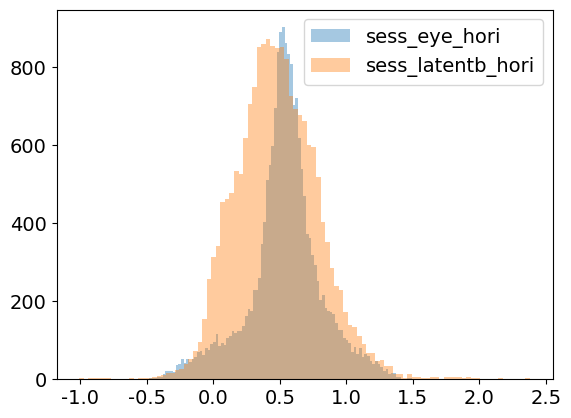

In [48]:
def mypack(list_of_variable_names):
    return dict((name, eval(name)) for name in list_of_variable_names)



def myhist(data, bins=99,alpha=0.4):
    for k,v in data.items():
        plt.hist(v, bins=bins,alpha=alpha, label=k)
    plt.legend()
    plt.show()
    
# myhist([sess_eye_hori,sess_latentb_hori])
data=mypack(['sess_eye_hori','sess_latentb_hori'])
myhist({'sess_eye_hori': normalizematrix(sess_eye_hori),
        'sess_latentb_hori':normalizematrix(sess_latentb_hori),
        })


## Sanity check

findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.


findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

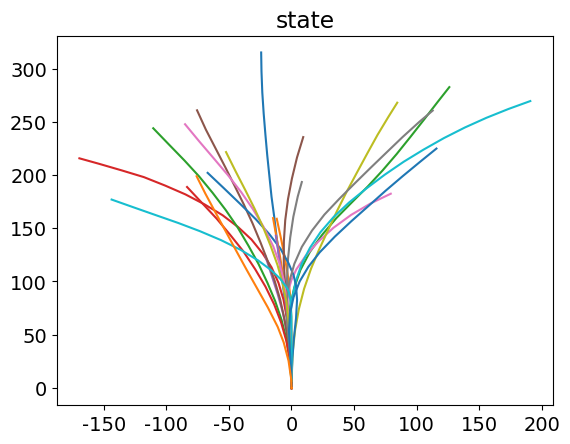

Text(0.5, 1.0, 'belief')

findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

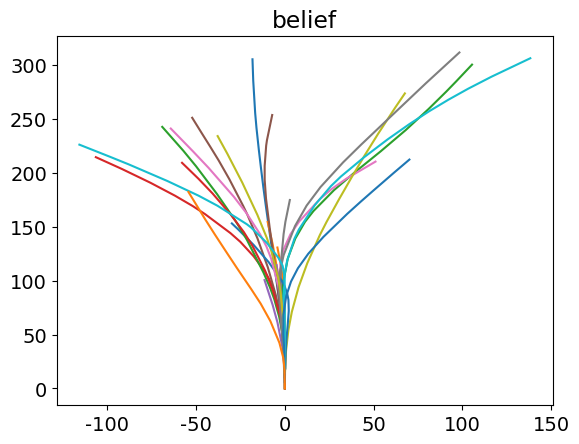

In [24]:
# sanity check. belief path should be similar to state path.
for itrial in range(22):
    (rel_dist, rel_ang, abs_dist, abs_ang,
                                    eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                    fx, fy, mx, my, mv, mw)=zip(*yy[itrial])
    plt.plot(mx, my)

    # plt.plot(np.arctan2(my,mx))
plt.title('state')
plt.show()
for ep_beliefs, ep_covs, task in zip(beliefs[:22], covs[:22], tasks[:22]):
    mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
    fx,fy=task[0]*worldscale, task[1]*worldscale
    mx, my = np.asarray(my).reshape(-1).astype('float')*worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale
    plt.plot(mx, my)
    # plt.plot(np.arctan2(my,mx))
plt.title('belief')

findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.


findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

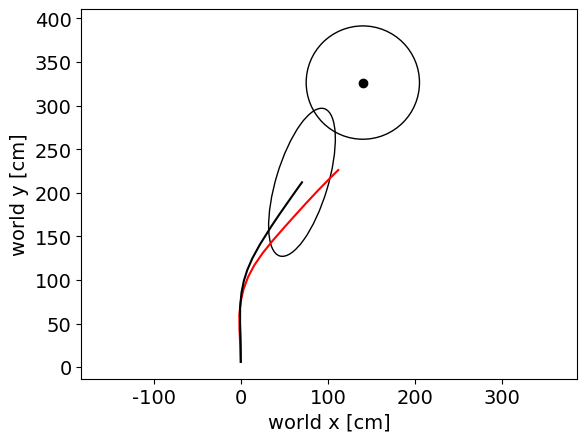

In [25]:
# plot state and belief together, visualize the belief cov and state stop

fig, ax=plt.subplots(1,1)
# for itrial in range(len(trial_idces)):
itrial-=1

# # y downsample states
# (rel_dist, rel_ang, abs_dist, abs_ang,
#                                 eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
#                                 fx, fy, mx, my, mv, mw)=zip(*yy[itrial])
# ep_err=distance((fx[-1]-mx[-1]),(fy[-1]-my[-1]))
# plt.plot( np.array(mx), my ,'g')

# pre irc states
ep_states=states[itrial]
mx, my, body_theta,  mv,mw= zip(*ep_states)
fx,fy=task[0]*worldscale, task[1]*worldscale
mx, my = np.asarray(my).reshape(-1).astype('float')*worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale
plt.plot( mx, my ,'r')

# belief path
ep_beliefs, ep_covs, task=beliefs[itrial], covs[itrial], tasks[itrial]
mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
fx,fy=task[0]*worldscale, task[1]*worldscale
mx, my = np.asarray(my).reshape(-1).astype('float')*worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale
plt.plot( mx, my ,'k')

# belief cov
cov=ep_covs[-1]
cov=cov[:2,:2]*worldscale*worldscale
flippedcov=np.array([[cov[1,1], cov[1,0]],[cov[0,1], cov[0,0]]]) # need to flip x and y 
plot_cov_ellipse(flippedcov, [mx[-1], my[-1]], alpha=1, nstd=3,edgecolor='black',  ax=ax)


# task
from matplotlib import patches
plt.scatter(fy,fx, color='k')
circle = patches.Circle((fy,fx), 65, fill=False)
plt.gca().add_patch(circle)
plt.xlabel('world x [cm]')
plt.ylabel('world y [cm]')
plt.axis('equal')
plt.show()


findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

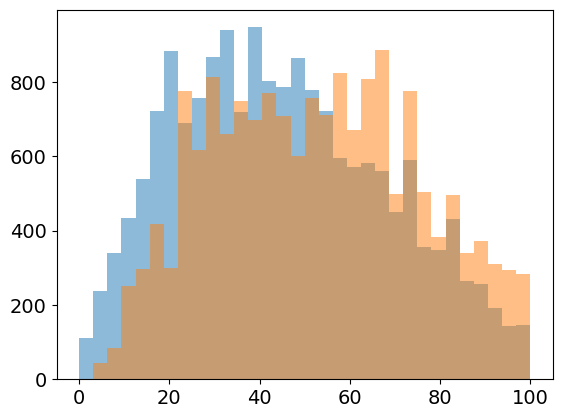

In [26]:
_=plt.hist(sess_err, bins=np.linspace(0,100,33), alpha=0.5)
_=plt.hist(sess_err_belief, bins=np.linspace(0,100,33), alpha=0.5)

findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

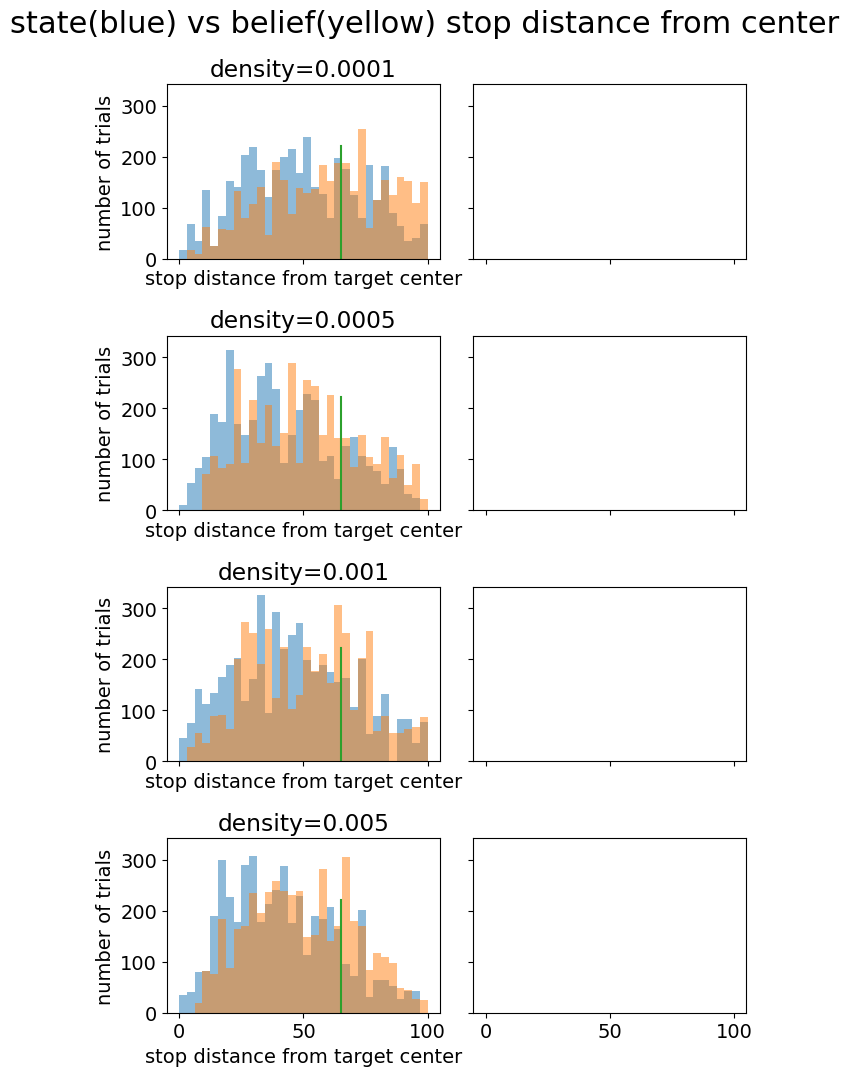

In [27]:
fig,axs=plt.subplots(4,2, figsize=(7,11), dpi=100,sharey=True,sharex=True,)
for i, den in enumerate([0.0001, 0.0005, 0.001,  0.005]):
    mask=(dens_t==den)

    ax=axs[i,0]
    _=ax.hist(sess_err[mask], bins=np.linspace(0,100,33), alpha=0.5)
    _=ax.hist(sess_err_belief[mask], bins=np.linspace(0,100,33), alpha=0.5)
    ax.plot([65,65],[0,222])
    # c=ax.scatter(sess_latentff_hori[mask], sess_latentb_hori[mask], c=sess_ll_t[mask],s=1, cmap='jet', vmax=44, alpha=0.3)
    # ax.plot([-50,50],[-50,50],'k')
    # ax.plot([-0,0],[-66,66],'k')
    ax.set_title(f'density={den}')
    ax.set_xlabel('stop distance from target center')
    ax.set_ylabel('number of trials')
    # fig.colorbar(c, ax=ax, label='negative log likelihood')

plt.suptitle('state(blue) vs belief(yellow) stop distance from center', fontsize=22)
plt.tight_layout()
plt.show()




findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

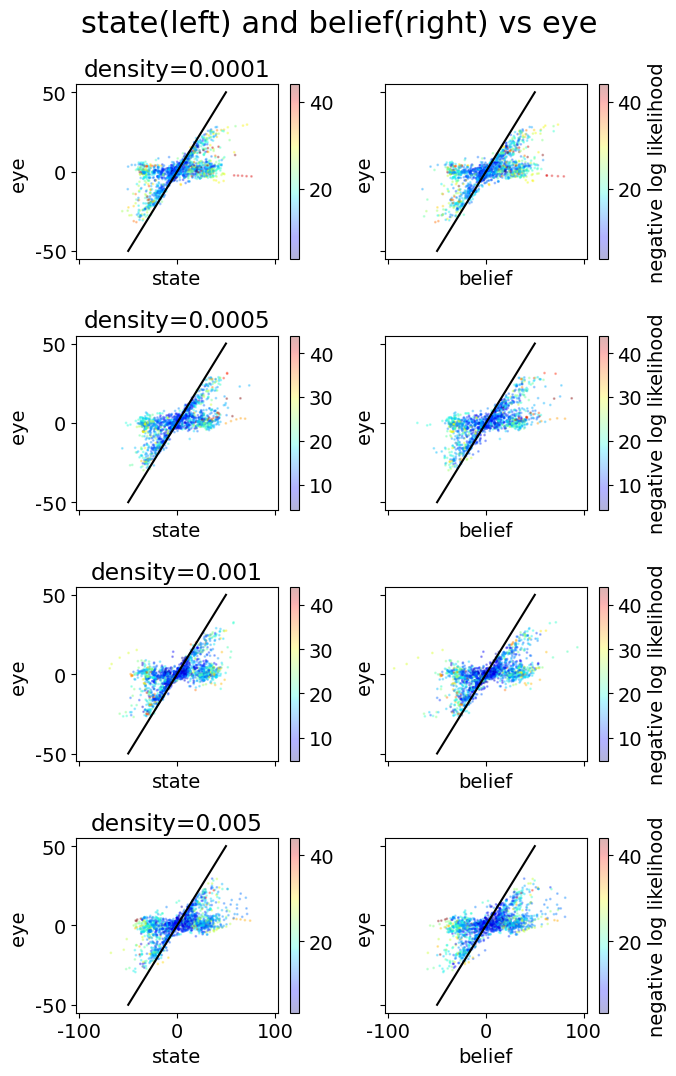

In [28]:
fig,axs=plt.subplots(4,2, figsize=(7,11), dpi=100,sharey=True,sharex=True,)
for i, den in enumerate([0.0001, 0.0005, 0.001,  0.005]):
    mask=(dens_t==den)&(sess_t<5)

    ax=axs[i,0]
    c=ax.scatter(sess_latentff_hori[mask], sess_eye_hori[mask], c=sess_ll_t[mask], s=1, alpha=0.3, cmap='jet', vmax=44)
    ax.set_title(f'density={den}')
    ax.plot([-50,50],[-50,50],'k')
    fig.colorbar(c, ax=ax)
    ax.set_xlabel('state')
    ax.set_ylabel('eye ')
    ax=axs[i,1]
    c=ax.scatter(sess_latentb_hori[mask], sess_eye_hori[mask], c=sess_ll_t[mask], s=1, alpha=0.3, cmap='jet', vmax=44)
    fig.colorbar(c, ax=ax, label='negative log likelihood')
    # ax.set_title('belief vs eye hori')
    ax.plot([-50,50],[-50,50],'k')
    ax.set_xlabel('belief')
    ax.set_ylabel('eye ')

plt.suptitle('state(left) and belief(right) vs eye', fontsize=22)
plt.tight_layout()
plt.show()

findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.


findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

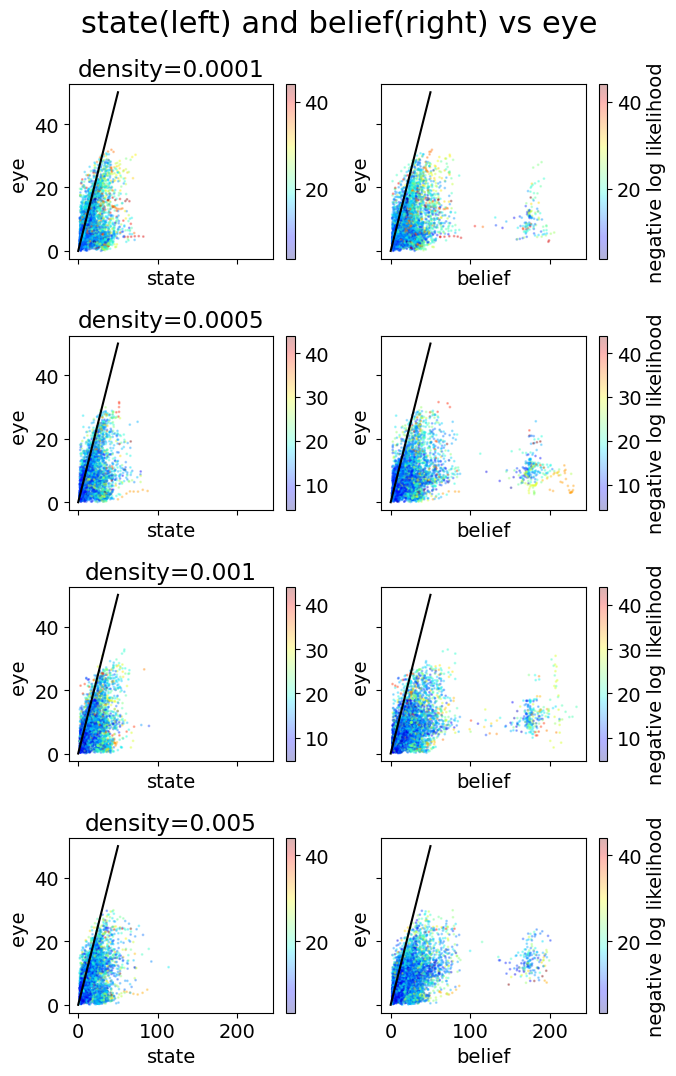

In [29]:
fig,axs=plt.subplots(4,2, figsize=(7,11), dpi=100,sharey=True,sharex=True,)
for i, den in enumerate([0.0001, 0.0005, 0.001,  0.005]):
    mask=(dens_t==den)

    ax=axs[i,0]
    c=ax.scatter(distance(sess_latentff_hori,sess_latentff_vert)[mask],distance(sess_eye_hori,sess_eye_vert)[mask], c=sess_ll_t[mask], s=1, alpha=0.3, cmap='jet', vmax=44)
    ax.set_title(f'density={den}')
    ax.plot([-0,50],[-0,50],'k')
    fig.colorbar(c, ax=ax)
    ax.set_xlabel('state')
    ax.set_ylabel('eye ')
    ax=axs[i,1]

    c=ax.scatter(distance(sess_latentb_hori,sess_latentb_vert)[mask],distance(sess_eye_hori,sess_eye_vert)[mask], c=sess_ll_t[mask], s=1, alpha=0.3, cmap='jet', vmax=44)
    fig.colorbar(c, ax=ax, label='negative log likelihood')
    # ax.set_title('belief vs eye hori')
    ax.plot([-0,50],[-0,50],'k')
    ax.set_xlabel('belief')
    ax.set_ylabel('eye ')

plt.suptitle('state(left) and belief(right) vs eye', fontsize=22)
plt.tight_layout()
plt.show()




findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.


findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

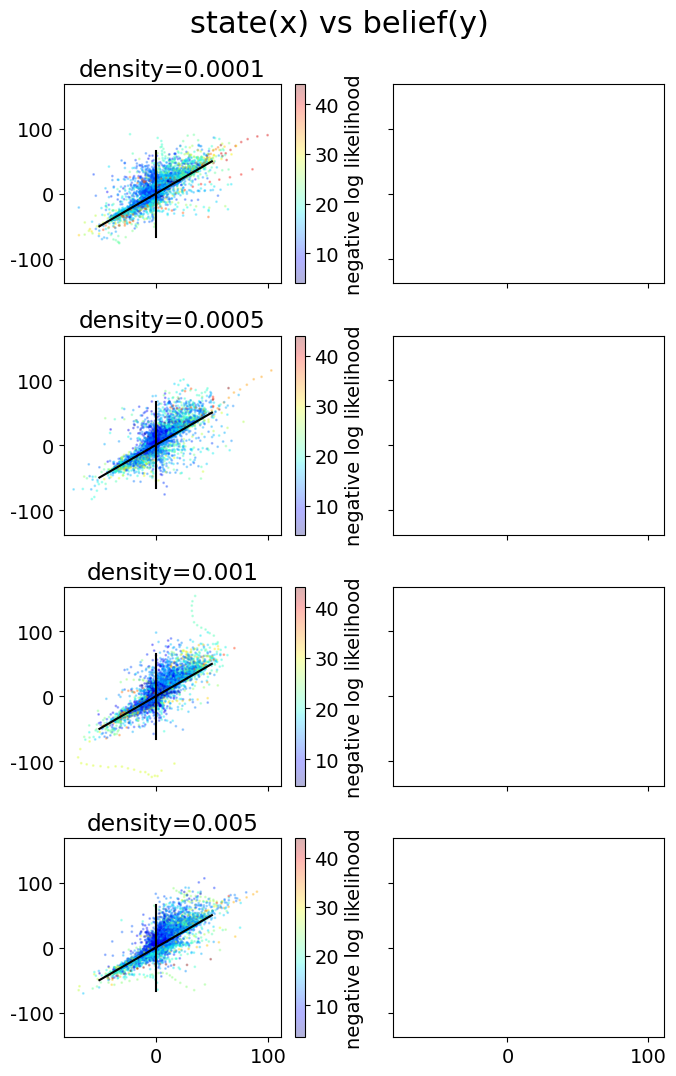

In [30]:
fig,axs=plt.subplots(4,2, figsize=(7,11), dpi=100,sharey=True,sharex=True,)
for i, den in enumerate([0.0001, 0.0005, 0.001,  0.005]):
    mask=(dens_t==den)

    ax=axs[i,0]
    c=ax.scatter(sess_latentff_hori[mask], sess_latentb_hori[mask], c=sess_ll_t[mask],s=1, cmap='jet', vmax=44, alpha=0.3)
    ax.plot([-50,50],[-50,50],'k')
    ax.plot([-0,0],[-66,66],'k')
    ax.set_title(f'density={den}')
    fig.colorbar(c, ax=ax, label='negative log likelihood')

plt.suptitle('state(x) vs belief(y)', fontsize=22)
plt.tight_layout()
plt.show()




findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

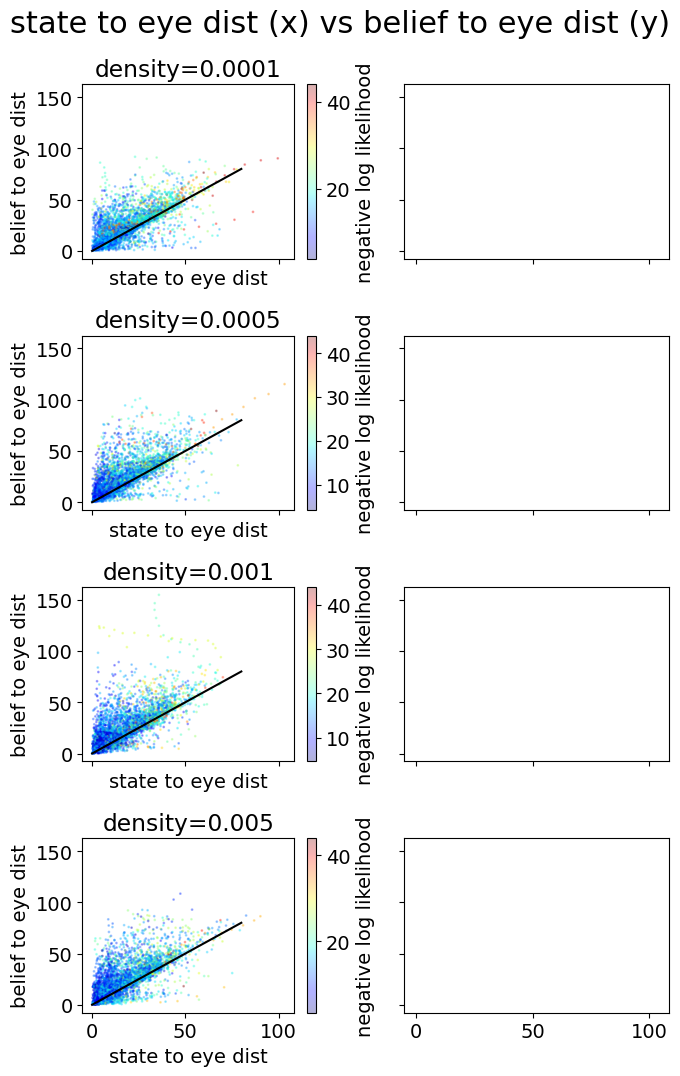

In [31]:
fig,axs=plt.subplots(4,2, figsize=(7,11), dpi=100,sharey=True,sharex=True,)
for i, den in enumerate([0.0001, 0.0005, 0.001,  0.005]):
    mask=(dens_t==den)
    ax=axs[i,0]

    bd, sd=distance(sess_latentb_hori, sess_eye_hori),distance(sess_latentff_hori, 
    sess_eye_hori)
    c=ax.scatter(sd[mask],bd[mask],c=sess_ll_t[mask], s=1,alpha=0.3, cmap='jet', vmax=44)
    # ax.set_title('belief vs state to eye dist hori')
    ax.plot([-0,80],[-0,80],'k')
    fig.colorbar(c, ax=ax, label='negative log likelihood')
    ax.set_xlabel('state to eye dist')
    ax.set_ylabel('belief to eye dist')
    ax.set_title(f'density={den}')


plt.suptitle('state to eye dist (x) vs belief to eye dist (y)', fontsize=22)
plt.tight_layout()
plt.show()


findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.


findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

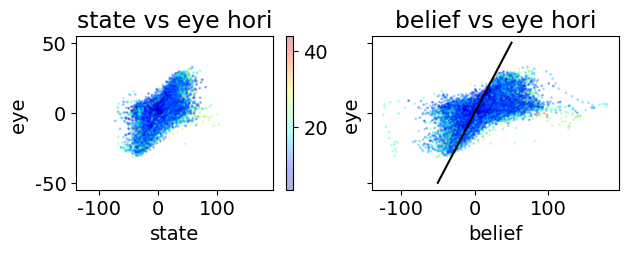

findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

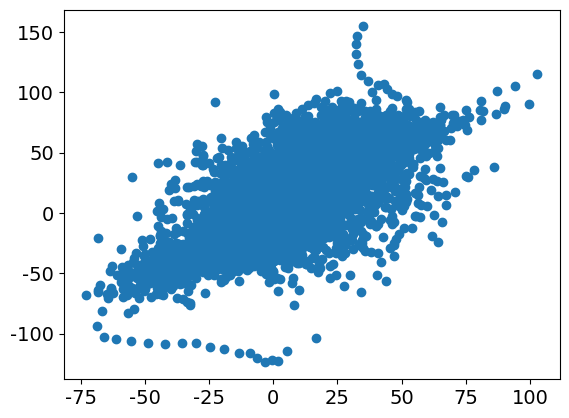

In [32]:
mask=np.ones_like(sess_t).astype('bool')
fig,axs=plt.subplots(1,2, figsize=(7,2), dpi=100,sharey=True,sharex=True,)
ax=axs[0]
ax.scatter(sess_latentff_hori[mask], sess_eye_hori[mask], c=sess_ll_t[mask], s=1, alpha=0.3, cmap='jet')
ax.set_title('state vs eye hori')
# ax.plot([-50,50],[-50,50],'k')
fig.colorbar(c, ax=ax)
ax.set_xlabel('state')
ax.set_ylabel('eye ')
ax=axs[1]
c=ax.scatter(sess_latentb_hori[mask], sess_eye_hori[mask], c=sess_ll_t[mask], s=1, alpha=0.3, cmap='jet')
# fig.colorbar(c, ax=ax)
ax.set_title('belief vs eye hori')
ax.plot([-50,50],[-50,50],'k')
ax.set_xlabel('belief')
ax.set_ylabel('eye ')
plt.show()
plt.scatter(sess_latentff_hori, sess_latentb_hori)

findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

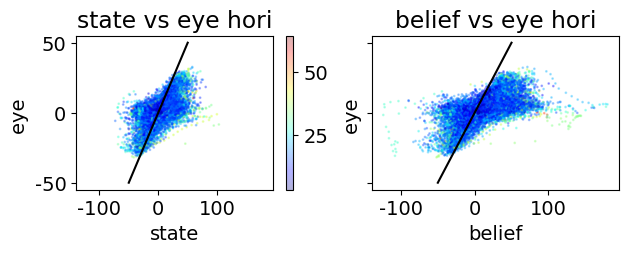

findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

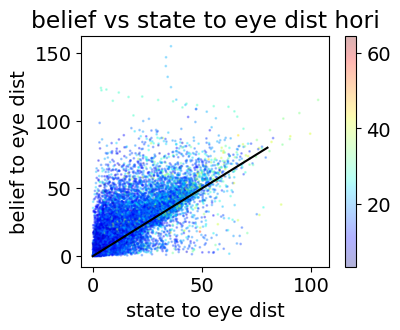

findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

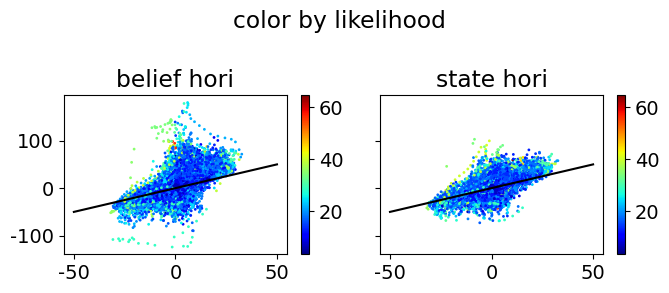

findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

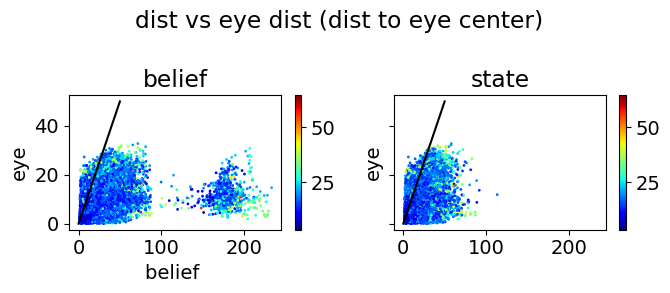

findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

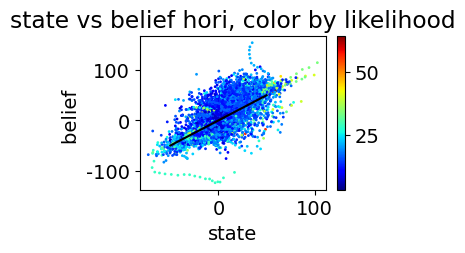

In [33]:
# mask the data 

# 
# mask=(sess_t<5)
# mask=(sess_err>65)
# mask=(sess_err_belief>65)
# mask=(sess_ll_t<20)
mask=np.ones_like(sess_t).astype('bool')

# mask=(dens_t==[0.0001, 0.0005, 0.001,  0.005][0])

fig,axs=plt.subplots(1,2, figsize=(7,2), dpi=100,sharey=True,sharex=True,)
ax=axs[0]
ax.scatter(sess_latentff_hori[mask], sess_eye_hori[mask], c=sess_ll_t[mask], s=1, alpha=0.3, cmap='jet')
ax.set_title('state vs eye hori')
ax.plot([-50,50],[-50,50],'k')
fig.colorbar(c, ax=ax)
ax.set_xlabel('state')
ax.set_ylabel('eye ')
ax=axs[1]
c=ax.scatter(sess_latentb_hori[mask], sess_eye_hori[mask], c=sess_ll_t[mask], s=1, alpha=0.3, cmap='jet')
# fig.colorbar(c, ax=ax)
ax.set_title('belief vs eye hori')
ax.plot([-50,50],[-50,50],'k')
ax.set_xlabel('belief')
ax.set_ylabel('eye ')
plt.show()


fig,axs=plt.subplots(1,1, sharey=True,sharex=True, figsize=(4,3),dpi=100)
bd, sd=distance(sess_latentb_hori, sess_eye_hori),distance(sess_latentff_hori, 
sess_eye_hori)
c=plt.scatter(sd[mask],bd[mask],c=sess_ll_t[mask], s=1,alpha=0.3, cmap='jet')
plt.title('belief vs state to eye dist hori')
plt.plot([-0,80],[-0,80],'k')
fig.colorbar(c, ax=axs)
plt.xlabel('state to eye dist')
plt.ylabel('belief to eye dist')
plt.show()


fig,axs=plt.subplots(1,2, sharey=True,sharex=True, figsize=(7,3),dpi=100)
ax=axs[0]
c=ax.scatter(sess_eye_hori[mask], sess_latentb_hori[mask], c=sess_ll_t[mask],s=1, cmap='jet')
ax.plot([-50,50],[-50,50],'k')
ax.set_title('belief hori')
fig.colorbar(c, ax=ax)
ax=axs[1]
c=ax.scatter(sess_eye_hori[mask], sess_latentff_hori[mask], c=sess_ll_t[mask],s=1, cmap='jet')
ax.plot([-50,50],[-50,50],'k')
ax.set_title('state hori')
fig.colorbar(c, ax=ax)
plt.suptitle('color by likelihood')
plt.tight_layout()
plt.show()

fig,axs=plt.subplots(1,2, sharex=True,sharey=True, figsize=(7,3),dpi=100)
ax=axs[0]
c=ax.scatter(distance(sess_latentb_hori,sess_latentb_vert)[mask],distance(sess_eye_hori,sess_eye_vert)[mask], c=sess_ll_t[mask],s=1, cmap='jet')
ax.plot([-0,50],[-0,50],'k')
fig.colorbar(c, ax=ax)
ax.set_title('belief')
ax.set_xlabel('belief ')
ax.set_ylabel('eye')
ax=axs[1]
c=ax.scatter(distance(sess_latentff_hori,sess_latentff_vert)[mask],distance(sess_eye_hori,sess_eye_vert)[mask], c=sess_ll_t[mask],s=1, cmap='jet')
ax.plot([-0,50],[-0,50],'k')
fig.colorbar(c, ax=ax)
ax.set_title('state')
plt.ylabel('eye')
ax.set_title('state')
plt.suptitle( 'dist vs eye dist (dist to eye center)')
plt.tight_layout()
plt.show()


fig,axs=plt.subplots(1,1, figsize=(3,2), dpi=100)
c=plt.scatter(sess_latentff_hori[mask], sess_latentb_hori[mask], c=sess_ll_t[mask],s=1, cmap='jet')
plt.plot([-50,50],[-50,50],'k')
plt.title('state vs belief hori, color by likelihood')
ax=plt.gca()
ax.set_xlabel('state')
ax.set_ylabel('belief ')
plt.colorbar(c)
plt.show()



## Angular task variables
angular variables are less affected by the stop/eye mismatch and the experiemnt design artifact.  
thus, irc belief explains the angular task variables, such as heading direction, better than the ground truth states.  
more specific, corr(belief, eye) > corr(state, eye)

In [34]:
def svb(thisx, thisb, thisy, thisc,mask, xlabel='x', ylabel='y'):
    fig,axs=plt.subplots(1,2, figsize=(6,2), dpi=100, sharex=True, sharey=True)
    ax=axs[0]
    c=ax.scatter(thisx[mask], thisy[mask], c=thisc[mask], s=1, cmap='jet')
    # ax=plt.gca()
    ax.set_xlabel(f'state {xlabel}')
    ax.set_ylabel(ylabel)
    ax.set_title(f' pearson r = {pearsonr(thisx[mask], thisy[mask])[0]:.2f}')
    # fig.colorbar(c)
    # plt.xlim(0,3.15)
    # plt.show()

    # fig,axs=plt.subplots(1,1, figsize=(3,2), dpi=100)
    
    ax=axs[1]
    c=ax.scatter(thisb[mask], thisy[mask], c=thisc[mask], s=1, cmap='jet')
    ax.set_xlabel(f'belief {xlabel}')
    ax.set_ylabel(ylabel)
    ax.set_title(f' pearson r = {pearsonr(thisb[mask], thisy[mask])[0]:.2f}')
    fig.colorbar(c, label='negative log liklihood')
    # plt.xlim(0, 3.15)
    plt.show()
    return fig

findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.


findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

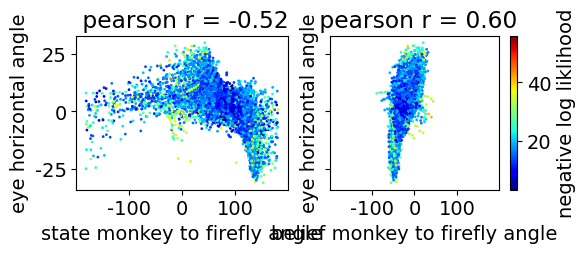

findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

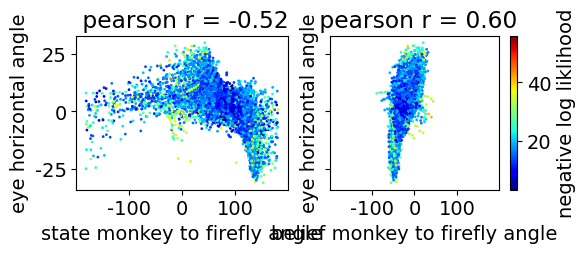

In [35]:
# use the f-m angle, t
mask=(sess_t>5)

# mask=~np.isnan(sess_t)
thisx=np.rad2deg(state_angle_f)
thisb=np.rad2deg(belief_angle_f)
thisy=sess_eye_hori
thisc=sess_ll_t
svb(thisx, thisb, thisy, thisc,mask, xlabel='monkey to firefly angle', ylabel='eye horizontal angle')

findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.


findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

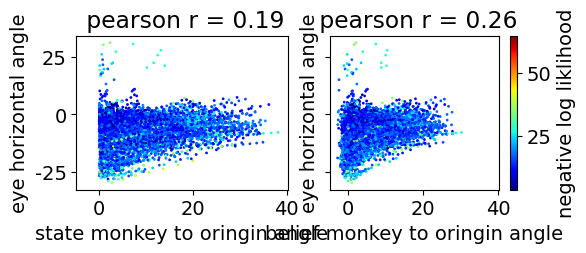

findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

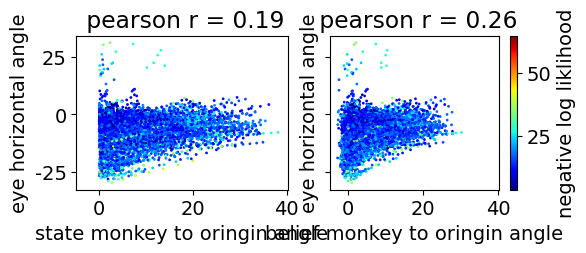

In [36]:
# use the m-o angle
mask=(sess_t>4)&(state_angle>0)
thisx=np.rad2deg(state_angle)
thisb=np.rad2deg(belief_angle)
thisy=-sess_eye_hori
thisc=sess_ll_t
svb(thisx, thisb, thisy, thisc,mask, xlabel='monkey to oringin angle', ylabel='eye horizontal angle')

In [37]:
# bins=np.linspace(-99,99,100)
# _=plt.hist((state_heading), bins=bins)
# _=plt.hist(np.rad2deg(belief_heading), bins=bins, alpha=0.5)
# plt.show()

# bins=np.linspace(-99,99,100)
# _=plt.hist((sess_eye_hori), bins=bins)


In [38]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

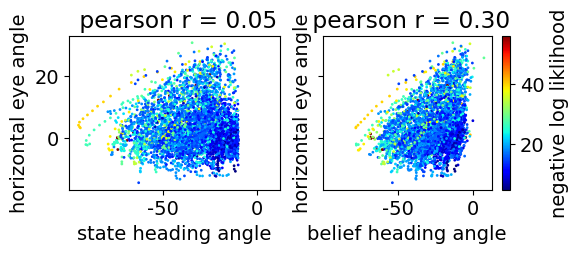

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

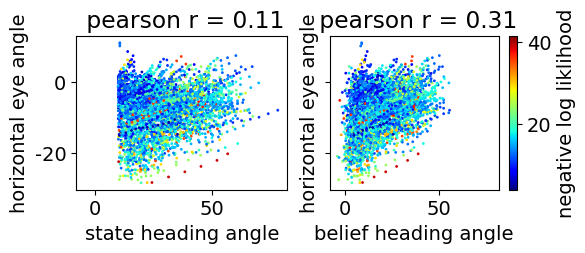

In [39]:
# use the heading angle
mask=((state_heading<-10)|(state_heading<-10)) &(sess_t>5)
thisx=(state_heading)
thisb=np.rad2deg(belief_heading)
thisy=-sess_eye_hori
thisc=sess_ll_t
fig=svb(thisx, thisb, thisy, thisc,mask, xlabel='heading angle', ylabel='horizontal eye angle')
fig.savefig(figure_path/'c5_belief_eye_corr.svg',bbox_inches='tight',dpi=300, transparent=True)  

mask=((state_heading>10)|(state_heading>10)) &(sess_t>5)
thisx=(state_heading)
thisb=np.rad2deg(belief_heading)
thisy=-sess_eye_hori
thisc=sess_ll_t
fig=svb(thisx, thisb, thisy, thisc,mask, xlabel='heading angle', ylabel='horizontal eye angle')




## Neural to heading direction

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

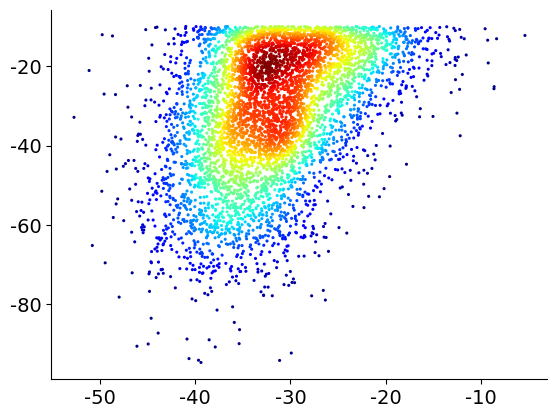

In [40]:
mask=(state_heading<-10) &(sess_t>0)
thiss=state_heading[mask]
thisb=np.rad2deg(belief_heading)[mask]
thise=-sess_eye_hori[mask]
thisx=r_ppc_t[mask]

lasso_wrap(thisx, thiss, title='neural predict state heading')
lasso_wrap(thisx, thisb, title='neural predict belief heading')
lasso_wrap(thisx, thise, title='neural predict eye direction')

In [ ]:
# normalize the heading angle and eye angle, such that the correlations can be compared.
lasso_wrap(thisx, normalizematrix(thiss)*100, title='neural predict state heading')
lasso_wrap(thisx, normalizematrix(thisb)*100, title='neural predict belief heading')
lasso_wrap(thisx, normalizematrix(thise)*100, title='neural predict eye direction')
# result shows neural is best correlated with eye, and less correlated to heading.

In [ ]:
fig,ax=plt.subplots(1,1)
ax.bar([1,2,3],[864.2475613973795,747.2995363410466,474.72061711156994], width=0.5)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['ground truth heading','inferred belief heading','horizontal eye angle'], rotation=45,ha='right')
ax.set_ylabel('M.S.E')
fig.savefig(figure_path/'c5_mse.svg',bbox_inches='tight',dpi=300, transparent=True)  


## CEBRA
get cebra data and use them in another notebook.

In [41]:
# make data for auto encoder
mask=np.ones_like(sess_t).astype('bool')
thisx=r_ppc_t[mask]
thisb=np.rad2deg(belief_heading)[mask]
thise=-sess_eye_hori[mask]
thisy=np.vstack([
    normalizematrix(sess_latentff_hori), # has nan
    normalizematrix(sess_latentff_vert), # has nan
    normalizematrix(sess_eye_hori), # eye
    normalizematrix(sess_eye_vert),
    normalizematrix(sess_latentb_hori),
    normalizematrix(sess_latentb_vert),
    normalizematrix(sess_angle_from_start),
    normalizematrix(sess_ll_t),
    normalizematrix(sess_t),
    normalizematrix(sess_err),
    normalizematrix(sess_err_belief),
    normalizematrix(sess_angle_from_start_belief),
    normalizematrix(np.rad2deg(belief_heading)), # belief heading
]).T[mask]

thisyname=[
    'sess_latentff_hori',
    'sess_latentff_vert',
    'sess_eye_hori',
    'sess_eye_vert',
    'sess_latentb_hori',
'sess_latentb_vert',
    '(sess_angle_from_start)',
    ('sess_ll_t'),
    ('sess_t'),
    ('sess_err'),
    ('sess_err_belief'),
    ('sess_angle_from_start_belief'),
    (('belief_heading')), # belief heading
]

# process
thisy[np.isnan(thisy)]=0 # sometime eye tracking is lost
thisy=np.clip(thisy,-1,1)

print(thisx.shape, thisy.shape)
print(np.sum(np.isnan(thisx)),np.sum(np.isnan(thisy)))



(18985, 94) (18985, 13)
0 0


In [42]:

with open(f'{workdir}/test/neural/cebra/0329fixeye','wb+') as f:
    pickle.dump((thisx, thisy),f)

## encoder decoder
use autoencoder  
    pro, nonlinear feature can automaticaly find  
    instructions:  
        left: neural activity (n, n neuron)  
        right: task var (n, n task feature)  
    analysis:   
        see the overlap  


In [ ]:
# define auto encoder object

import torch
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


class autoencoder(nn.Module):
    def __init__(self, ninput, noutput,latent=3):
        # this is a customized autoencoder
        # n input features and n output features.
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(ninput, 128),
                                     nn.ReLU(True),
                                     nn.Linear(128, 64),
                                     nn.ReLU(True),
                                     nn.Linear(64, 16),
                                     nn.ReLU(True),
                                     nn.Linear(16, latent),
                                     nn.Dropout(p=0.2),  # Apply dropout
                                    nn.BatchNorm1d(latent)  # Apply batch normalization
                                    )
        self.decoder = nn.Sequential(nn.Linear(latent, 16),
                                     nn.ReLU(True),
                                     nn.Dropout(p=0.2),
                                     nn.Linear(16, 64),
                                     nn.ReLU(True),
                                     
                                     nn.Linear(64, 128),
                                     nn.ReLU(True),
                                     nn.Linear(128, noutput),
                                     nn.Tanh())
        self.latent=latent
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode





In [ ]:
# make data for auto encoder

thisx=r_ppc_t[mask]
thisb=np.rad2deg(belief_heading)[mask]
thise=-sess_eye_hori[mask]
thisy=np.vstack([
    normalizematrix(sess_latentff_hori), # has nan
    normalizematrix(sess_latentff_vert), # has nan
    normalizematrix(-sess_eye_hori), # eye
    normalizematrix(sess_eye_vert),
    normalizematrix(sess_latentb_hori),
    normalizematrix(sess_latentb_vert),
    normalizematrix(sess_angle_from_start),
    normalizematrix(sess_ll_t),
    normalizematrix(sess_t),
    normalizematrix(sess_err),
    normalizematrix(sess_err_belief),
    normalizematrix(sess_angle_from_start_belief),
    normalizematrix(np.rad2deg(belief_heading)), # belief heading
]).T[mask]

thisyname=[
    'sess_latentff_hori',
    'sess_latentff_vert',
    'sess_eye_hori',
    'sess_eye_vert',
    'sess_latentb_hori',
'sess_latentb_vert',
    '(sess_angle_from_start)',
    ('sess_ll_t'),
    ('sess_t'),
    ('sess_err'),
    ('sess_err_belief'),
    ('sess_angle_from_start_belief'),
    (('belief_heading')), # belief heading
]

# process
thisy[np.isnan(thisy)]=0 # sometime eye tracking is lost
thisy=np.clip(thisy,-1,1)

print(thisx.shape, thisy.shape)
print(np.sum(np.isnan(thisx)),np.sum(np.isnan(thisy)))


# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(thisx, thisy, test_size=0.2, random_state=42)

# Convert your data into PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Define batch size
batch_size = 32

# Create DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
[(i,t) for (i,t) in enumerate(thisyname)]

In [ ]:
torch.cuda.is_available()
!pip show torch

In [ ]:
# run auto encoder

# 超参数设置
lr = 1e-4
weight_decay = 1e-5
epoches = 33
model = autoencoder(thisx.shape[1], thisy.shape[1],latent=4)
criterion = nn.MSELoss()
optimizier = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

if torch.cuda.is_available():
    model.cuda()
for epoch in range(epoches):
    model.train()
    if epoch in [epoches * 0.25, epoches * 0.5]:
        for param_group in optimizier.param_groups:
            param_group['lr'] *= 0.1
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.view(batch_x.size(0), -1)
        batch_x = Variable(batch_x.cuda())
        batch_y=Variable(batch_y.cuda())

        # forward
        _, output = model(batch_x)
        loss = criterion(output, batch_y)

        # backward
        optimizier.zero_grad()
        loss.backward()
        optimizier.step()
    print("epoch =", epoch, 'epoch loss =',loss.clone().detach().item())


    if (epoch+1) % 5 == 0:
        # on test set
        model.eval()
        with torch.no_grad():
            batch_x, batch_y=x_test_tensor, y_test_tensor
            batch_x = batch_x.view(batch_x.size(0), -1)
            batch_x = Variable(batch_x.cuda())
            batch_y=Variable(batch_y.cuda())

            # forward
            _, output = model(batch_x)
            loss = criterion(output, batch_y)
        print("\nepoch =", epoch, 'test loss =',loss.clone().detach().item())

        for param_group in optimizier.param_groups:
            print(param_group['lr'])
        print('\n')

    #     print("epoch: {}, loss is {}".format((epoch+1), loss.data))
        # loss on test set
       

        # # visualization
        # with torch.no_grad():
        #         batch_x, batch_y=next(iter(test_loader))
        #         batch_x = batch_x.view(batch_x.size(0), -1)
        #         batch_x = Variable(batch_x.cuda())
        #         batch_y=Variable(batch_y.cuda())

        #         # forward
        #         _, output = model(batch_x)
        #         loss = criterion(output, batch_y)

        #         fig,axs = plt.subplots(1, 2, figsize=(8, 6))  
        #         ax=axs[0]
        #         c=ax.imshow(output.clone().detach().cpu().numpy(), vmin=-1,vmax=1)
        #         ax.set_title('output')
        #         # add_colorbar(c,ax=ax)
        #         ax=axs[1]      
        #         c=ax.imshow(batch_y.clone().detach().cpu().numpy(), vmin=-1,vmax=1)
        #         add_colorbar(c,ax=ax)
        #         ax.set_title('batch y')
        #         plt.show()

In [ ]:
trainiter=iter(train_loader)

In [ ]:
# train set
batch_x, batch_y=next(trainiter)
with torch.no_grad():
    model.eval()
    # for batch_x, batch_y in test_loader:
    batch_x = batch_x.view(batch_x.size(0), -1)
    batch_x = Variable(batch_x.cuda())
    batch_y=Variable(batch_y.cuda())

    # forward
    _, output = model(batch_x)
    loss = criterion(output, batch_y)

    fig,axs = plt.subplots(1, 2, figsize=(8, 6))  
    ax=axs[0]
    c=ax.imshow(output.clone().detach().cpu().numpy(), cmap='bwr',vmin=-1,vmax=1)
    ax.set_title('output')
    ax.set_ylabel('batch samples')
    # ax.set_xlabel('task var')
    ax.set_xticks(np.arange(len(thisyname)))
    ax.set_xticklabels(thisyname, rotation=90)
    # add_colorbar(c,ax=ax)
    ax=axs[1]      
    c=ax.imshow(batch_y.clone().detach().cpu().numpy(),cmap='bwr', vmin=-1,vmax=1)
    add_colorbar(c,ax=ax)
    ax.set_title('batch y')
    # ax.set_xlabel('task var')
    ax.set_xticks(np.arange(len(thisyname)))
    ax.set_xticklabels(thisyname, rotation=90 )
    plt.show()


In [ ]:
testiter=iter(test_loader)

In [ ]:
# test set
# batch_x, batch_y=next(testiter)
with torch.no_grad():
    model.eval()
    # for batch_x, batch_y in test_loader:
    batch_x = batch_x.view(batch_x.size(0), -1)
    batch_x = Variable(batch_x.cuda())
    batch_y=Variable(batch_y.cuda())

    # forward
    _, output = model(batch_x)
    loss = criterion(output, batch_y)

    fig,axs = plt.subplots(1, 2, figsize=(8, 6))  
    ax=axs[0]
    c=ax.imshow(output.clone().detach().cpu().numpy(), cmap='bwr',vmin=-1,vmax=1)
    ax.set_title('output')
    ax.set_ylabel('batch samples')
    # ax.set_xlabel('task var')
    ax.set_xticks(np.arange(len(thisyname)))
    ax.set_xticklabels(thisyname, rotation=90)
    # add_colorbar(c,ax=ax)
    ax=axs[1]      
    c=ax.imshow(batch_y.clone().detach().cpu().numpy(),cmap='bwr', vmin=-1,vmax=1)
    add_colorbar(c,ax=ax)
    ax.set_title('batch y')
    # ax.set_xlabel('task var')
    ax.set_xticks(np.arange(len(thisyname)))
    ax.set_xticklabels(thisyname, rotation=90 )
    plt.show()



### check per feature error

In [ ]:
with torch.no_grad():
    batch_x, batch_y=x_test_tensor, y_test_tensor
    batch_x = batch_x.view(batch_x.size(0), -1)
    batch_x = Variable(batch_x.cuda())
    batch_y=Variable(batch_y.cuda())

    # forward
    _, output = model(batch_x)
    loss = criterion(output, batch_y)
    print("epoch =", epoch, 'test loss = {:.3f}'.format(loss.clone().detach().item()))

loss_var=[criterion(output[:,i], batch_y[:,i]).clone().detach().item() for i in range(output.shape[1])]
sortind=np.argsort(loss_var)

for i in range(output.shape[1]):
    print(f'{loss_var[sortind[i]] :.3f}, {thisyname[sortind[i]]}')
# sortind,thisyname[sortind[i]]
    

In [ ]:
s=555;e= s+100
plt.plot(sess_angle_from_start[s:e])
plt.plot(sess_angle_from_start_belief[s:e])

### check weight contribution

we want to know how much of ith neuron influence the jth latent dim and then kth belief var
use 0000100 (one at ith) input to drive the network.

In [ ]:
# use 1 hot neural input to map the encoder weights
encode_w=torch.zeros(batch_x.shape[1],model.latent)
for i in range(batch_x.shape[1]):
    pertinput=Variable(torch.zeros(1, batch_x.shape[1]))
    pertinput[0,i]=1.

    encode, decode = model(pertinput.cuda())    
    encode_w[i]=encode.clone().detach().cpu()
    

In [ ]:
fig,ax = plt.subplots(1, 1, figsize=(4, 3)) 
c=ax.imshow(encode_w, aspect='auto',interpolation='none', cmap='bwr', vmin=-1, vmax=1)
add_colorbar(c, aspect=99)
ax.set_xticks(np.arange(model.latent))
plt.xlabel('latent')
plt.ylabel('neural input')

In [ ]:
# use 1 hot latent input to map the decoder weights
decode_w=torch.zeros(model.latent, batch_y.shape[1])
for i in range(model.latent):
    pertinput=Variable(torch.zeros(1, model.latent))
    pertinput[0,i]=1.

    decode = model.decoder(pertinput.cuda())[0]
    decode_w[i]=decode.clone().detach().cpu()
    

In [ ]:
fig,ax = plt.subplots(1, 1, figsize=(5, 3)) 
c=ax.imshow(decode_w, aspect='auto',interpolation='none', cmap='bwr', vmin=-1, vmax=1)
add_colorbar(c, aspect=11, pad_fraction=2)
ax.set_xticks(np.arange(len(thisyname)))
ax.set_xticklabels(thisyname, rotation=45,ha='right' )
plt.ylabel('latent')
plt.xlabel('task var output')

### check weight contribution (increment)

instead of using 1 hot vector, we use an small increment at a time. from empty input to 1 hot vector

In [ ]:
for x in np.linspace(0,1,5):
    # use 1 hot neural input to map the encoder weights
    encode_w=torch.zeros(batch_x.shape[1],model.latent)
    for i in range(batch_x.shape[1]):
        pertinput=Variable(torch.zeros(1, batch_x.shape[1]))
        pertinput[0,i]=x

        encode, decode = model(pertinput.cuda())    
        encode_w[i]=encode.clone().detach().cpu()
    fig,ax = plt.subplots(1, 1, figsize=(4, 3)) 
    c=ax.imshow(encode_w, aspect='auto',interpolation='none', cmap='bwr', vmin=-1, vmax=1)
    add_colorbar(c, aspect=999)
    ax.set_xticks(np.arange(model.latent))
    plt.xlabel('latent')
    plt.ylabel('neural input')
    plt.title(f'input 1 hot vector * {x}')
    plt.show()

In [ ]:
for x in np.linspace(0,1,3):
    # use 1 hot latent input to map the decoder weights
    decode_w=torch.zeros(model.latent, batch_y.shape[1])
    for i in range(model.latent):
        pertinput=Variable(torch.zeros(1, model.latent))
        pertinput[0,i]=x

        decode = model.decoder(pertinput.cuda())[0]
        decode_w[i]=decode.clone().detach().cpu()
    fig,ax = plt.subplots(1, 1, figsize=(5, 3)) 
    c=ax.imshow(decode_w, aspect='auto',interpolation='none', cmap='bwr', vmin=-1, vmax=1)
    add_colorbar(c, aspect=11, pad_fraction=2)
    ax.set_xticks(np.arange(len(thisyname)))
    ax.set_xticklabels(thisyname, rotation=45,ha='right' )
    plt.ylabel('latent')
    plt.xlabel('task var output') 
    plt.title(f'input 1 hot vector * {x}')
    plt.show()

In [ ]:
# if we add a difference
# eg, assian the previous ch to be -1
for x in np.linspace(0,1,3):
    # use 1 hot latent input to map the decoder weights
    decode_w=torch.zeros(model.latent, batch_y.shape[1])
    for i in range(model.latent):
        pertinput=Variable(torch.zeros(1, model.latent))
        pertinput[0,i]=x
        pertinput[0,i-1]=-1

        decode = model.decoder(pertinput.cuda())[0]
        decode_w[i]=decode.clone().detach().cpu()
    fig,ax = plt.subplots(1, 1, figsize=(5, 3)) 
    c=ax.imshow(decode_w, aspect='auto',interpolation='none', cmap='bwr', vmin=-1, vmax=1)
    add_colorbar(c, aspect=11, pad_fraction=2)
    ax.set_xticks(np.arange(len(thisyname)))
    ax.set_xticklabels(thisyname, rotation=45,ha='right' )
    plt.ylabel('latent')
    plt.xlabel('task var output') 
    plt.title(f'input 1 hot vector * {x}')
    plt.show()

### what neural activity pattern (or which neuron) max drives the task variable?
we can use an optimizer to max the output. 

In [ ]:
maxdrive=[]
for target_index in range(batch_y.shape[1]):
    networkinput=torch.zeros(1,model.latent,requires_grad=True, device='cuda:0')
    # Define the index var you want to maximize the output of
    criterion = lambda output: -output[0, target_index]
    # Define optimizer
    optimizer = optim.SGD([networkinput], lr=0.1)
    # Optimization loop
    for i in range(999):
        # Forward pass
        output = model.decoder(networkinput)
        # Compute loss
        loss = criterion(output)
        # Zero gradients
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        # Update input image
        optimizer.step()

        # if not i%555:
        #     print(loss.clone().detach().item())

    tensor=networkinput.clone().detach()
    min_vals, max_vals = torch.min(tensor), torch.max(tensor)
    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    maxdrive.append(normalized_tensor)
maxdrive=torch.concat(maxdrive)

In [ ]:
fig,ax = plt.subplots(1, 1, figsize=(5, 3)) 
c=ax.imshow(maxdrive.cpu().numpy(), aspect='auto',interpolation='none', cmap='bwr')
add_colorbar(c, aspect=33, pad_fraction=1)
ax.set_yticks(np.arange(len(thisyname)))
ax.set_yticklabels(thisyname)#, rotation=45,ha='right' )
# plt.xlabel('latent')
plt.xlabel('latent vector') 
ax.set_xticks([])
plt.title(f'latent vectors that max drive task variable (row)')
plt.show()

In [ ]:
maxdrive=[]
for target_index in range(model.latent):
    networkinput=torch.zeros(1,batch_x.shape[1],requires_grad=True, device='cuda:0')
    # Define the index var you want to maximize the output of
    criterion = lambda output: -output[0, target_index]
    # Define optimizer
    optimizer = optim.SGD([networkinput], lr=0.1)
    # Optimization loop
    for i in range(999):
        # Forward pass
        output = model.encoder(networkinput)
        # Compute loss
        loss = criterion(output)
        # Zero gradients
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        # Update input image
        optimizer.step()

        if not i%555:
            print(loss.clone().detach().item())
    print('end')
    tensor=networkinput.clone().detach()
    min_vals, max_vals = torch.min(tensor), torch.max(tensor)
    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    maxdrive.append(normalized_tensor)
maxdrive=torch.concat(maxdrive)

In [ ]:
fig,ax = plt.subplots(1, 1, figsize=(5, 3)) 
c=ax.imshow(maxdrive.cpu().numpy(), aspect='auto',interpolation='none', cmap='bwr')
add_colorbar(c, aspect=1, pad_fraction=2)
ax.set_yticks(np.arange(model.latent))
# ax.set_yticklabels(thisyname)#, rotation=45,ha='right' )
plt.ylabel('latent')
plt.xlabel('neural activity pattern') 
ax.set_xticks([])
plt.title(f'neural activity patter that max drive latent space (row)')
plt.show()

## try other networks: seq to seq autoencoder

In [ ]:
# seq seq ae

import torch
import torch.nn as nn

class Seq2SeqAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, dropout=0.0):
        super(Seq2SeqAutoencoder, self).__init__()
        self.encoder = nn.GRU(input_size, hidden_size, batch_first=True)
        self.encoder_dropout = nn.Dropout(dropout)
        self.decoder = nn.GRU(hidden_size, input_size, batch_first=True)
        self.decoder_dropout = nn.Dropout(dropout)
        self.latent_size = latent_size

    def forward(self, x):
        # Encoder
        _, (hidden, cell) = self.encoder(x)
        hidden = self.encoder_dropout(hidden)
        # Extract the hidden state as the latent representation
        latent_representation = hidden.view(-1, self.latent_size).unsqueeze(1)
        # Decoder
        output, _ = self.decoder(latent_representation)
        output = self.decoder_dropout(output)
        return output


In [ ]:
# make data for auto encoder
mask=(state_heading<-10) &(sess_t>0)
thisx=r_ppc_t[mask]
thisb=np.rad2deg(belief_heading)[mask]
thise=-sess_eye_hori[mask]
thisy=np.vstack([
    normalizematrix(sess_latentff_hori), # has nan
    normalizematrix(sess_latentff_vert), # has nan
    normalizematrix(-sess_eye_hori), # eye
    normalizematrix(sess_eye_vert),
    normalizematrix(sess_latentb_hori),
    normalizematrix(sess_latentb_vert),
    normalizematrix(sess_angle_from_start),
    normalizematrix(sess_ll_t),
    (sess_t),
    normalizematrix(sess_err),
    normalizematrix(sess_err_belief),
    normalizematrix(sess_angle_from_start_belief),
    normalizematrix(np.rad2deg(belief_heading)), # belief heading
]).T[mask]

thisyname=[
    'sess_latentff_hori',
    'sess_latentff_vert',
    'sess_eye_hori',
    'sess_eye_vert',
    'sess_latentb_hori',
'sess_latentb_vert',
    '(sess_angle_from_start)',
    ('sess_ll_t'),
    ('sess_t'),
    ('sess_err'),
    ('sess_err_belief'),
    ('sess_angle_from_start_belief'),
    (('belief_heading')), # belief heading
]

# process
thisy[np.isnan(thisy)]=0 # sometime eye tracking is lost
# thisy=np.clip(thisy,-1,1)

print(thisx.shape, thisy.shape)
print(np.sum(np.isnan(thisx)),np.sum(np.isnan(thisy)))


# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(thisx, thisy, test_size=0.2, random_state=42)

# Convert your data into PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Define batch size
batch_size = 64

# Create DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

time_list = sess_t
# Find indices where time_list resets to 0
trial_indices = [i for i, t in enumerate(time_list) if t == 0]
# print(trial_indices)
# print(sess_t[trial_indices[1]:trial_indices[2]])

data_list = thisx
# Split data_list into trials using trial_indices
trials = [data_list[i:j] for i, j in zip(trial_indices, trial_indices[1:] + [len(data_list)])]
trial_tensors = [torch.tensor(trial) for trial in trials]
# print(trial_tensors[0].shape) # triallen, features
# Determine the maximum lengths of sequences
x_data=trial_tensors
max_length = max(len(seq) for seq in x_data)
print('maxlen', max_length)
# Pad sequences to the same length
x_padded = torch.cat([torch.cat([seq, torch.zeros((max_length - seq.size(0), seq.size(1)), dtype=torch.int)]) for seq in x_data], dim=0)
x_padded.shape # ntrial*maxlen , feature
x_tensor = torch.tensor(x_padded)
print(x_tensor.shape)


data_list = thisy
# Split data_list into trials using trial_indices
trials = [data_list[i:j] for i, j in zip(trial_indices, trial_indices[1:] + [len(data_list)])]
trial_tensors = [torch.tensor(trial) for trial in trials]
print(thisyname[8])
print([(t.shape, t[:,8]) for t in trials])
print(sess_t[:30])

# print(trial_tensors[0].shape) # triallen, features
y_data=trial_tensors
# Pad sequences to the same length
y_padded = torch.cat([torch.cat([seq, torch.zeros((max_length - seq.size(0), seq.size(1)), dtype=torch.int)]) for seq in y_data], dim=0)
y_tensor = torch.tensor(y_padded)
print(y_tensor.shape)



In [ ]:
[t.shape for t in y_data]
y_padded = torch.cat([torch.cat([seq, torch.zeros((max_length - seq.size(0), seq.size(1)), dtype=torch.int)]) for seq in y_data], dim=0)
y_tensor[27*1:27*2,:]

plotdata=y_tensor[27*1:27*2,:].T
print(plotdata.shape)
print(y_tensor[27*1:27*2,:][8], normalizematrix(sess_t)[27*1:27*2])

fig,ax= plt.subplots(1, 1, figsize=(5, 8)) 

vlim=max(-1*torch.min(plotdata), torch.max(plotdata))
c=ax.imshow(plotdata.cpu().numpy(), aspect='auto',interpolation='none', cmap='bwr',vmin=-vlim, vmax=vlim)
add_colorbar(c, aspect=22, pad_fraction=2)
# ax.set_yticks(np.arange(model.latent))
# ax.set_yticklabels(thisyname)#, rotation=45,ha='right' )
ax.set_xlabel('timestamp')
ax.set_ylabel('task variable') 
ax.set_yticks(np.arange(len(thisyname)))
ax.set_yticklabels(thisyname)
ax.set_title(f'reconstructed')

In [ ]:
# make data

# Specify batch size for DataLoader
batch_size = 32

data_concatenated = y_tensor  # Concatenated tensor of shape (27*100 trials, 13)
# Reshape the data into a 3D tensor
num_trials = data_concatenated.size(0) // max_length
n_feature = y_tensor.shape[1]
data_reshaped = data_concatenated.view(num_trials, max_length, n_feature)
# Create a TensorDataset from the reshaped tensor
dataset = TensorDataset(data_reshaped, data_reshaped)  # Autoencoder: input and target are the same
data_loader_y = DataLoader(dataset, batch_size=batch_size, shuffle=False)

data_concatenated = x_tensor  # Concatenated tensor of shape (27*100 trials, 13)
# Reshape the data into a 3D tensor
num_trials = data_concatenated.size(0) // max_length
n_feature = x_tensor.shape[1]
data_reshaped = data_concatenated.view(num_trials, max_length, n_feature)
# Create a TensorDataset from the reshaped tensor
dataset = TensorDataset(data_reshaped, data_reshaped)  # Autoencoder: input and target are the same
data_loader_x = DataLoader(dataset, batch_size=batch_size, shuffle=False)



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torch
import torch.nn as nn

class LSTMEncoderDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.5):
        super(LSTMEncoderDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.num_layers=num_layers

    def forward(self, input_seq, max_len):
        batch_size = input_seq.size(0)
        
        # Initialize hidden and cell states for encoder and decoder
        hidden_encoder = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(input_seq.device)
        cell_encoder = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(input_seq.device)
        
        hidden_decoder = hidden_encoder.clone()  # Initialize decoder hidden state with encoder's last hidden state
        cell_decoder = cell_encoder.clone()  # Initialize decoder cell state with encoder's last cell state
        
        # Encoder forward pass
        _, (hidden_encoder, cell_encoder) = self.encoder(input_seq, (hidden_encoder, cell_encoder))
        
        # Initialize decoder input with zeros
        decoder_input = torch.zeros(batch_size, 1, self.hidden_dim).to(input_seq.device)
        
        # Output sequence tensor
        output_seq = torch.zeros(batch_size, max_len, self.linear.out_features).to(input_seq.device)
        
        # Decoder forward pass
        for t in range(max_len):
            decoder_output, (hidden_decoder, cell_decoder) = self.decoder(decoder_input, (hidden_decoder, cell_decoder))
            output = self.linear(decoder_output.squeeze(1))
            output_seq[:, t, :] = output
            decoder_input = decoder_output  # Use output as input for the next time step
        
        # output_seq = output_seq.flip(1)
        return output_seq

# Example usage
input_dim = 13
hidden_dim = 32
output_dim = input_dim
max_len = 27
model = LSTMEncoderDecoder(input_dim, hidden_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# input_seq = torch.randn(batch_size, max_len, input_dim)  # Example input sequence
# print('\ninput (batch, seqlen, feature)\n', input_seq.shape)

# output_seq = model(input_seq, max_len)
# print('\n output (batch, seqlen, feature)\n', output_seq.shape)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Parameters:", total_params)

num_epochs=10
learning_rate=0.005
sequence_length=max_len

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

data_loader = data_loader_y

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for input_seq, target_seq in data_loader:
        optimizer.zero_grad()
        output_seq = model(input_seq.float().to(device), max_len)
        
        # mask = (input_seq!=0)
        # if torch.sum(mask)==0:
        #     continue
        # loss = criterion(output_seq[mask], target_seq.float().to(device)[mask])
     
        loss = criterion(output_seq, target_seq.float().to(device))

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(data_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

In [ ]:
batch_size = 1

data_concatenated = y_tensor  # Concatenated tensor of shape (27*100 trials, 13)
# Reshape the data into a 3D tensor
num_trials = data_concatenated.size(0) // max_length
n_feature = y_tensor.shape[1]
data_reshaped = data_concatenated.view(num_trials, max_length, n_feature)
# Create a TensorDataset from the reshaped tensor
dataset = TensorDataset(data_reshaped, data_reshaped)  # Autoencoder: input and target are the same
data_loader_y = DataLoader(dataset, batch_size=batch_size, shuffle=False)

data_iter = iter(data_loader_y)

In [ ]:
with torch.no_grad():
    model.cpu()
    model.eval()
    input_seq,target_seq = next(data_iter)
    input_seq=torch.zeros_like(input_seq)
    output_seq = model(input_seq.float(), max_len)
    # print(input_seq)

plotdata=output_seq[0].clone().detach().T
print(plotdata.shape)

fig,axs = plt.subplots(2, 1, figsize=(9, 8)) 
ax=axs[0]
vlim=max(-1*torch.min(plotdata), torch.max(plotdata))
c=ax.imshow(plotdata.cpu().numpy(), aspect='auto',interpolation='none', cmap='bwr',vmin=-vlim, vmax=vlim)
add_colorbar(c, aspect=22, pad_fraction=2)
# ax.set_yticks(np.arange(model.latent))
# ax.set_yticklabels(thisyname)#, rotation=45,ha='right' )
ax.set_xlabel('timestamp')
ax.set_ylabel('task variable') 
ax.set_yticks(np.arange(len(thisyname)))
ax.set_yticklabels(thisyname)
ax.set_title(f'reconstructed')

plotdata=input_seq[0].clone().detach().T
print(plotdata.shape)
vlim=max(-1*torch.min(plotdata), torch.max(plotdata))
ax=axs[1]
c=ax.imshow(plotdata.cpu().numpy(), aspect='auto',interpolation='none', cmap='bwr',vmin=-vlim, vmax=vlim)
add_colorbar(c, aspect=22, pad_fraction=2)
# ax.set_yticks(np.arange(model.latent))
# ax.set_yticklabels(thisyname)#, rotation=45,ha='right' )
ax.set_xlabel('timestamp')
ax.set_ylabel('task variable') 
ax.set_yticks(np.arange(len(thisyname)))
ax.set_yticklabels(thisyname)
ax.set_title(f'oringinal')

plt.tight_layout()
plt.show()
notify()

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Create some example data
num_samples = 1000
seq_length = 20
input_dim = 10
data = torch.randn(num_samples, seq_length, input_dim)

# Custom collate function to reset latent state at start/end of sequence
def collate_fn(batch):
    batch = torch.stack(batch, dim=0)
    batch_size, seq_length, input_dim = batch.size()
    # Reset latent state at the start and end of each sequence
    batch[:, 0, :] = 0  # Reset at start
    batch[:, -1, :] = 0  # Reset at end
    return batch

# Create DataLoader
batch_size = 32
dataset = CustomDataset(data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Example usage in training loop
for epoch in range(num_epochs):
    for input_data in dataloader:
        optimizer.zero_grad()
        output = model(input_data)
        loss = criterion(output, input_data)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


## Consider the combination features
neurons could tuned to signal variance and noise variance. if so, a neuron 1 - neuron 2 could actually better tuned to the signal.
that is, a combination feature of (neuron1, neuron 2) is better than single neuron. 
we hope to find that.

### basic check

In [ ]:
mask=(state_heading<-7) &(sess_t>0)
# thiss=state_heading[mask]
# thisb=np.rad2deg(belief_heading)[mask]
# thise=-sess_eye_hori[mask]
thisx=r_ppc_t[mask]
thisx.shape
np.cov(thisx.T).shape
tmpdata=np.cov(thisx.T)
vlim=np.max(np.abs(tmpdata))

c=plt.imshow(np.cov(thisx.T), cmap='bwr', vmin=-vlim, vmax=vlim)
add_colorbar(c)
plt.title('correlation of the neural data')
plt.xlabel('# neuron')
plt.ylabel('# neuron')

### combination feature, multiplication

In [ ]:
# make x (neural)
thisx=r_ppc_t[mask]
# Expand dimensions to make broadcasting possible
expanded_data = np.expand_dims(thisx, axis=1)  # Shape: (n, 1, x)
# Perform element-wise multiplication to get pairwise combinations
pairwise_combinations = expanded_data *  np.expand_dims(thisx, axis=2)  # Shape: (n, x, 1) 
pairwise_combinations.shape
thisx=pairwise_combinations.reshape(len(pairwise_combinations), -1)

# feature extraction on x
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(thisx)

pca=PCA(n_components=100)
pca.fit(data_scaled.T)
first_components = pca.components_.T
print(first_components.shape)

# # pca on new data
# data_transformed = pca.transform(data_scaled)

# # inverse pca
# data_scaled = pca.inverse_transform(data_transformed)
# original_data = scaler.inverse_transform(data_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('# pca features')
plt.ylabel('% var explained')
plt.title('PCA var explained for multiplication combination feature')

thisx=first_components

In [ ]:
# make y (task variable)
thisb=np.rad2deg(belief_heading)[mask]
thise=-sess_eye_hori[mask]
thisy=np.vstack([normalizematrix(thisb)*100, normalizematrix(thise)*100]).T
thisy.shape

lasso=lasso_wrap_multi(thisx,thisy)

In [ ]:
lasso.coef_.shape
# plt.plot(lasso.coef_.T)

xs=np.arange(len(lasso.coef_.T))
belief_neurons=xs[(abs(lasso.coef_[0].T)>10)]
eye_neurons=xs[(abs(lasso.coef_[1].T)>10)]

shared_neurons=list(set(belief_neurons).intersection(set(eye_neurons)))
belief_only_neurons=list(set(belief_neurons).difference(set(shared_neurons)))
eye_only_neurons=list(set(eye_neurons).difference(set(shared_neurons)))


xs=np.arange(len(shared_neurons))
plt.bar(xs,lasso.coef_[0].T[shared_neurons],alpha=0.5, label='belief encoding weights')
plt.bar(xs,lasso.coef_[1].T[shared_neurons],alpha=0.5, label='eye encoding weights')
plt.legend()
plt.xlabel('neuron index')
plt.ylabel('neuron normalized encoding weights')
plt.title('neurons that encode both eye and belief')
plt.show()

xs=np.arange(len(belief_only_neurons))
plt.bar(xs,lasso.coef_[0].T[belief_only_neurons],alpha=0.5, label='belief encoding weights')
plt.bar(xs,lasso.coef_[1].T[belief_only_neurons],alpha=0.5, label='eye encoding weights')
plt.legend()
plt.xlabel('neuron index')
plt.ylabel('neuron normalized encoding weights')
plt.title('neurons that only encodes belief')
plt.show()


xs=np.arange(len(eye_only_neurons))
plt.bar(xs,lasso.coef_[0].T[eye_only_neurons],alpha=0.5, label='belief encoding weights')
plt.bar(xs,lasso.coef_[1].T[eye_only_neurons],alpha=0.5, label='eye encoding weights')
plt.legend()
plt.xlabel('neuron index')
plt.ylabel('neuron normalized encoding weights')
plt.title('neurons that only encodes eye')

### CCA on combination feature (pairwise)

In [ ]:
# make x (neural)
thisx=r_ppc_t[mask]
# Expand dimensions to make broadcasting possible
expanded_data = np.expand_dims(thisx, axis=1)  # Shape: (n, 1, x)
# Perform element-wise multiplication to get pairwise combinations
pairwise_combinations = expanded_data *  np.expand_dims(thisx, axis=2)  # Shape: (n, x, 1) 
pairwise_combinations.shape
thisx=pairwise_combinations.reshape(len(pairwise_combinations), -1)

# feature extraction on x
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(thisx)

pca=PCA(n_components=100)
pca.fit(data_scaled.T)
first_components = pca.components_.T
print(first_components.shape)
thix=first_components

# make y (task variable)
print(thisx.shape, thisy.shape)
thisy=np.vstack([
    normalizematrix(sess_latentff_hori)*100,
    normalizematrix(sess_latentff_vert)*100,
    normalizematrix(-sess_eye_hori)*100, # eye
    normalizematrix(sess_eye_vert)*100,
    normalizematrix(sess_latentb_hori)*100,
    normalizematrix(sess_latentb_vert)*100,
    normalizematrix(sess_angle_from_start)*100,
    normalizematrix(sess_ll_t)*100,
    normalizematrix(sess_t)*100,
    normalizematrix(sess_err)*100,
    normalizematrix(sess_err_belief)*100,
    normalizematrix(sess_angle_from_start_belief)*100,
    normalizematrix(np.rad2deg(belief_heading))*100, # belief heading
    
]).T[mask]

print(thisx.shape, thisy.shape)

thisy[np.isnan(thisy)]=0

In [ ]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=3) 
thisxc, thisyc = cca.fit_transform(thisx, thisy)


In [ ]:
plt.plot(sorted(cca.x_rotations_[:,0])[::-1][:100])
plt.plot(sorted(cca.x_rotations_[:,1])[::-1][:100])
plt.plot(sorted(cca.x_rotations_[:,2])[::-1][:100])
plt.title('CCA weights neural-->latent')
plt.xlabel('# neural feature')
plt.xlabel('weight')

In [ ]:
plt.plot(sorted(abs(cca.y_rotations_[:,0]))[::-1][:100])
plt.plot(sorted(abs(cca.y_rotations_[:,1]))[::-1][:100])
plt.plot(sorted(abs(cca.y_rotations_[:,2]))[::-1][:100])
plt.title('CCA weights task vars-->latent')
plt.xlabel('# task vars')
plt.xlabel('weight')

In [ ]:
print(np.argsort(abs(cca.y_rotations_[:,0]))[::-1])
print(np.argsort(abs(cca.y_rotations_[:,1]))[::-1])
print(np.argsort(abs(cca.y_rotations_[:,2]))[::-1])

## find eye only neurons and heading only neurons (lasso) 
there should be some neurons encoding only the heading direction, and some only for eye direction.
to remove the irrelavent neurons, we use lasso to apply a regularization to the linear regression weights, such that the irrelavent neurons will have 0 weights.
we can then sort the weights by absolute values and know which neuron is more important in linearly encoding the eye/heading direction

In [ ]:
mask=(state_heading<-10) &(sess_t>0)
thiss=state_heading[mask]
thisb=np.rad2deg(belief_heading)[mask]
thise=-sess_eye_hori[mask]
thisx=r_ppc_t[mask]

# lasso fit and check the weights
ns_weights, ns_winds=lasso_wrap_weights(thisx, normalizematrix(thiss)*100, title='neural predict state heading')
nb_weights, nb_winds=lasso_wrap_weights(thisx, normalizematrix(thisb)*100, title='neural predict state heading')
ne_weights, ne_winds=lasso_wrap_weights(thisx, normalizematrix(thise)*100, title='neural predict state heading')

# plt.plot(ns_weights)
xs=np.arange(len(nb_weights))
plt.bar(xs,nb_weights, label='belief encoding weights')
plt.bar(xs,ne_weights, label='eye encoding weights')
plt.legend()
plt.xlabel('neuron index')
plt.ylabel('neuron normalized encoding weights')

the raw neuron weights encoding the belief heading direction and eye.  

In [ ]:
# the seperated neurons
firstn=min(20, len(nb_weights))
sortinds=np.argsort(np.abs(nb_weights-ne_weights))[::-1]
xs=np.arange(firstn)
plt.bar(xs,nb_weights[sortinds][:firstn],alpha=0.5, label='belief encoding weights')
plt.bar(xs,ne_weights[sortinds][:firstn],alpha=0.5, label='eye encoding weights')
plt.legend()
plt.xlabel('neuron index')
plt.ylabel('neuron normalized encoding weights')
plt.title('sorted by the largest difference in weights')

if we sort the neurons by their difference in weights to belief and eye, we can see there are some neurons have very difference weights for the two variables

In [ ]:
# the shared neurons 
mask=(abs(nb_weights)>10)&(abs(ne_weights)>10)
firstn=min(20, len(nb_weights[mask]))
sortinds=np.argsort(np.abs(nb_weights[mask]-ne_weights[mask]))[::1]
xs=np.arange(firstn)
plt.bar(xs,nb_weights[mask][sortinds][:firstn],alpha=0.5, label='belief encoding weights')
plt.bar(xs,ne_weights[mask][sortinds][:firstn],alpha=0.5, label='eye encoding weights')
plt.legend()
plt.xlabel('neuron index')
plt.ylabel('neuron normalized encoding weights')
plt.title('sorted by the smallest difference in weights')
fig.savefig(figure_path/'c5_shared.pdf',bbox_inches='tight')

if we sort the neurons by their difference in weights to belief and eye, we can see some neurons encode both variables.

In [ ]:
xs=np.arange(len(nb_weights))
belief_neurons=xs[(abs(nb_weights)>10)]
eye_neurons=xs[(abs(ne_weights)>10)]
shared_neurons=list(set(belief_neurons).intersection(set(eye_neurons)))
belief_only_neurons=list(set(belief_neurons).difference(set(shared_neurons)))
eye_only_neurons=list(set(eye_neurons).difference(set(shared_neurons)))

# shared_neurons, belief_only_neurons, eye_only_neurons

In [ ]:

xs=np.arange(len(shared_neurons))
plt.bar(xs,nb_weights[shared_neurons],alpha=0.5, label='belief encoding weights')
plt.bar(xs,ne_weights[shared_neurons],alpha=0.5, label='eye encoding weights')
plt.legend()
plt.xlabel('neuron index')
plt.ylabel('neuron normalized encoding weights')
plt.title('neurons that encode both eye and belief')
plt.savefig(figure_path/'c5_encodeboth.pdf',bbox_inches='tight')
plt.savefig(figure_path/'c5_encode both.svg',bbox_inches='tight',dpi=300, transparent=True)  

we can select the eye or belief only neurons by removing the shared neurons.

In [ ]:

xs=np.arange(len(belief_only_neurons))
plt.bar(xs,nb_weights[belief_only_neurons],alpha=0.5, label='belief encoding weights')
plt.bar(xs,ne_weights[belief_only_neurons],alpha=0.5, label='eye encoding weights')
plt.legend()
plt.xlabel('neuron index')
plt.ylabel('neuron normalized encoding weights')
plt.title('neurons that only encodes belief')
plt.savefig(figure_path/'c5_encodebelief.svg',bbox_inches='tight',dpi=300, transparent=True)  

belief only neurons

In [ ]:

xs=np.arange(len(eye_only_neurons))
plt.bar(xs,nb_weights[eye_only_neurons],alpha=0.5, label='belief encoding weights')
plt.bar(xs,ne_weights[eye_only_neurons],alpha=0.5, label='eye encoding weights')
plt.legend()
plt.xlabel('neuron index')
plt.ylabel('neuron normalized encoding weights')
plt.title('neurons that only encodes eye')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(figure_path/'c5_encodeeye.svg',bbox_inches='tight',dpi=300, transparent=True)  

eye only neurons

## Multi linear regression lasso

from the previous lasso analysis, we see there are some neurons are only tuned to belief heading direction instead of eye.
there could be different reasons:
- eye and heading direction is tightly correlated but not in linear relationship. in this task, we can see most of the time, heading directions is corrlated to eye stronly. but the transition from the world coord to eye coord has distortion thus not linear. when seeing some neurons only correlated to belief heading instead of the eye, we might be looking at the neurons that are more active (depend on time or angle) at the largest distortion site.
- we might found something interesting! eg, the brain is doing early stage prediction (something that is different from observation and belief) from motor feedback signals. and later this will be used to compute belief.

we can check the activation patterns of those neurons and have a better sense. eg, if the selective tuning neuron is more activated at a specific time, at a specific angle, it could mean something.

In [ ]:
mask=(state_heading<-7) &(sess_t>0)
thiss=state_heading[mask]
thisb=np.rad2deg(belief_heading)[mask]
thise=-sess_eye_hori[mask]
thisx=r_ppc_t[mask]

lr_x=thisx
lr_y=np.vstack([normalizematrix(thisb)*100, normalizematrix(thise)*100]).T


from sklearn.linear_model import MultiTaskLassoCV

def lasso_wrap_multi(X, y, num_folds=5,title='title'):
    
    # Initialize k-fold cross-validation
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Initialize LassoCV model
    lasso_cv = MultiTaskLassoCV(cv=kf, random_state=42)

    # Lists to store scores and best alphas from each fold
    scores = []
    best_alphas = []

    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X):
        # print(X.shape, y.shape, max(train_index), max(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        lasso_cv.fit(X_train, y_train)

        best_alpha = lasso_cv.alpha_
        best_alphas.append(best_alpha)

        predictions = lasso_cv.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        scores.append(mse)

    # Calculate the average score and best alpha across folds
    avg_score = np.mean(scores)
    avg_alpha = np.mean(best_alphas)

    print(f"Average Mean Squared Error across {num_folds} folds: {avg_score}")
    print(f"Average Best alpha across {num_folds} folds: {avg_alpha}")
    return lasso_cv

lasso=lasso_wrap_multi(lr_x,lr_y)


In [ ]:
lasso.coef_.shape
# plt.plot(lasso.coef_.T)

xs=np.arange(len(lasso.coef_.T))
belief_neurons=xs[(abs(lasso.coef_[0].T)>10)]
eye_neurons=xs[(abs(lasso.coef_[1].T)>10)]

shared_neurons=list(set(belief_neurons).intersection(set(eye_neurons)))
belief_only_neurons=list(set(belief_neurons).difference(set(shared_neurons)))
eye_only_neurons=list(set(eye_neurons).difference(set(shared_neurons)))


xs=np.arange(len(shared_neurons))
plt.bar(xs,lasso.coef_[0].T[shared_neurons],alpha=0.5, label='belief encoding weights')
plt.bar(xs,lasso.coef_[1].T[shared_neurons],alpha=0.5, label='eye encoding weights')
plt.legend()
plt.xlabel('neuron index')
plt.ylabel('neuron normalized encoding weights')
plt.title('neurons that encode both eye and belief')
plt.show()

xs=np.arange(len(belief_only_neurons))
plt.bar(xs,lasso.coef_[0].T[belief_only_neurons],alpha=0.5, label='belief encoding weights')
plt.bar(xs,lasso.coef_[1].T[belief_only_neurons],alpha=0.5, label='eye encoding weights')
plt.legend()
plt.xlabel('neuron index')
plt.ylabel('neuron normalized encoding weights')
plt.title('neurons that only encodes belief')
plt.show()


xs=np.arange(len(eye_only_neurons))
plt.bar(xs,lasso.coef_[0].T[eye_only_neurons],alpha=0.5, label='belief encoding weights')
plt.bar(xs,lasso.coef_[1].T[eye_only_neurons],alpha=0.5, label='eye encoding weights')
plt.legend()
plt.xlabel('neuron index')
plt.ylabel('neuron normalized encoding weights')
plt.title('neurons that only encodes eye')

### When (trial timer) do the selective neuron matter

eg, the 1st (0 indexing) belief selective neuron, shows high activation at the begining of trial.

In [ ]:
eye_only_neurons, belief_only_neurons, shared_neurons
plot_i=0
for plot_i in range(len(belief_only_neurons)):  
    print(f'\n\nplotting {plot_i}th belief selective neuron')
    mask=(state_heading<-7) & (sess_t>0)& (sess_t<5)
    thisx=100*normalizematrix(r_ppc_t)[mask]
    data2plot=thisx[:,belief_only_neurons]
    plt.hist(data2plot[:,plot_i], bins=np.linspace(.05,150,20)); plt.title(np.mean(data2plot[:,plot_i]));plt.show()

    mask=(state_heading<-7) & (sess_t>5)& (sess_t<10)
    thisx=100*normalizematrix(r_ppc_t)[mask]
    data2plot=thisx[:,belief_only_neurons]
    plt.hist(data2plot[:,plot_i], bins=np.linspace(.05,150,20)); plt.title(np.mean(data2plot[:,plot_i]));plt.show()

    mask=(state_heading<-7) & (sess_t>10)& (sess_t<15)
    thisx=100*normalizematrix(r_ppc_t)[mask]
    data2plot=thisx[:,belief_only_neurons]
    plt.hist(data2plot[:,plot_i], bins=np.linspace(.05,150,20)); plt.title(np.mean(data2plot[:,plot_i]));plt.show()

    mask=(state_heading<-7) & (sess_t>15)& (sess_t<20)
    thisx=100*normalizematrix(r_ppc_t)[mask]
    data2plot=thisx[:,belief_only_neurons]
    plt.hist(data2plot[:,plot_i], bins=np.linspace(.05,150,20)); plt.title(np.mean(data2plot[:,plot_i]));plt.show()


as for eye selective neurons, besides high activation at begining neurons, we also see some neurons shows an increase of activation near the end of trial.
might be preparing to look at new target?

In [ ]:
eye_only_neurons, belief_only_neurons, shared_neurons
plot_i=0
for plot_i in range(len(eye_only_neurons)):  
    print(f'\n\nplotting {plot_i}th eye selective neuron')
    mask=(state_heading<-7) & (sess_t>0)& (sess_t<5)
    thisx=100*normalizematrix(r_ppc_t)[mask]
    data2plot=thisx[:,eye_only_neurons]
    plt.hist(data2plot[:,plot_i], bins=np.linspace(.05,150,20)); plt.title(np.mean(data2plot[:,plot_i]));plt.show()

    mask=(state_heading<-7) & (sess_t>5)& (sess_t<10)
    thisx=100*normalizematrix(r_ppc_t)[mask]
    data2plot=thisx[:,eye_only_neurons]
    plt.hist(data2plot[:,plot_i], bins=np.linspace(.05,150,20)); plt.title(np.mean(data2plot[:,plot_i]));plt.show()

    mask=(state_heading<-7) & (sess_t>10)& (sess_t<15)
    thisx=100*normalizematrix(r_ppc_t)[mask]
    data2plot=thisx[:,eye_only_neurons]
    plt.hist(data2plot[:,plot_i], bins=np.linspace(.05,150,20)); plt.title(np.mean(data2plot[:,plot_i]));plt.show()

    mask=(state_heading<-7) & (sess_t>15)& (sess_t<20)
    thisx=100*normalizematrix(r_ppc_t)[mask]
    data2plot=thisx[:,eye_only_neurons]
    plt.hist(data2plot[:,plot_i], bins=np.linspace(.05,150,20)); plt.title(np.mean(data2plot[:,plot_i]));plt.show()


### When (heading angle) do the selective neuron matter



In [ ]:
eye_only_neurons, belief_only_neurons, shared_neurons
plot_i=0
for plot_i in range(len(belief_only_neurons)):  
    print(f'\n\nplotting {plot_i}th belief selective neuron')
    mask=(state_heading<0) & (state_heading>-5)& (sess_t>0) #& (sess_t<5)
    thisx=100*normalizematrix(r_ppc_t)[mask]
    data2plot=thisx[:,belief_only_neurons]
    plt.hist(data2plot[:,plot_i], bins=np.linspace(.05,150,20)); plt.title(np.mean(data2plot[:,plot_i]));plt.show()

    mask=(state_heading<-5) & (state_heading>-10)& (sess_t>0) #& (sess_t<5)
    thisx=100*normalizematrix(r_ppc_t)[mask]
    data2plot=thisx[:,belief_only_neurons]
    plt.hist(data2plot[:,plot_i], bins=np.linspace(.05,150,20)); plt.title(np.mean(data2plot[:,plot_i]));plt.show()

    mask=(state_heading<-10) & (state_heading>-15)& (sess_t>0) #& (sess_t<5)
    thisx=100*normalizematrix(r_ppc_t)[mask]
    data2plot=thisx[:,belief_only_neurons]
    plt.hist(data2plot[:,plot_i], bins=np.linspace(.05,150,20)); plt.title(np.mean(data2plot[:,plot_i]));plt.show()

    mask=(state_heading<-15) & (state_heading>-20)& (sess_t>0) #& (sess_t<5)
    thisx=100*normalizematrix(r_ppc_t)[mask]
    data2plot=thisx[:,belief_only_neurons]
    plt.hist(data2plot[:,plot_i], bins=np.linspace(.05,150,20)); plt.title(np.mean(data2plot[:,plot_i]));plt.show()

    mask=(state_heading<-20)& (sess_t>0) #& (sess_t<5)
    thisx=100*normalizematrix(r_ppc_t)[mask]
    data2plot=thisx[:,belief_only_neurons]
    plt.hist(data2plot[:,plot_i], bins=np.linspace(.05,150,20)); plt.title(np.mean(data2plot[:,plot_i]));plt.show()


In [ ]:
eye_only_neurons, belief_only_neurons, shared_neurons
plot_i=0
for plot_i in range(len(eye_only_neurons)):  
    print(f'\n\nplotting {plot_i}th belief selective neuron')
    mask=(state_heading<0) & (state_heading>-5)& (sess_t>0) #& (sess_t<5)
    thisx=100*normalizematrix(r_ppc_t)[mask]
    data2plot=thisx[:,eye_only_neurons]
    plt.hist(data2plot[:,plot_i], bins=np.linspace(.05,150,20)); plt.title(np.mean(data2plot[:,plot_i]));plt.show()

    mask=(state_heading<-5) & (state_heading>-10)& (sess_t>0) #& (sess_t<5)
    thisx=100*normalizematrix(r_ppc_t)[mask]
    data2plot=thisx[:,eye_only_neurons]
    plt.hist(data2plot[:,plot_i], bins=np.linspace(.05,150,20)); plt.title(np.mean(data2plot[:,plot_i]));plt.show()

    mask=(state_heading<-10) & (state_heading>-15)& (sess_t>0) #& (sess_t<5)
    thisx=100*normalizematrix(r_ppc_t)[mask]
    data2plot=thisx[:,eye_only_neurons]
    plt.hist(data2plot[:,plot_i], bins=np.linspace(.05,150,20)); plt.title(np.mean(data2plot[:,plot_i]));plt.show()

    mask=(state_heading<-15) & (state_heading>-20)& (sess_t>0) #& (sess_t<5)
    thisx=100*normalizematrix(r_ppc_t)[mask]
    data2plot=thisx[:,eye_only_neurons]
    plt.hist(data2plot[:,plot_i], bins=np.linspace(.05,150,20)); plt.title(np.mean(data2plot[:,plot_i]));plt.show()

    mask=(state_heading<-20)& (sess_t>0) #& (sess_t<5)
    thisx=100*normalizematrix(r_ppc_t)[mask]
    data2plot=thisx[:,eye_only_neurons]
    plt.hist(data2plot[:,plot_i], bins=np.linspace(.05,150,20)); plt.title(np.mean(data2plot[:,plot_i]));plt.show()


## When neuron->belief is better than eye->belief

we can fit 2 linear models, one predict belief from eye, one predict belief from neural.
then, we can check the mse for each predicted belief data point, and compare the two models.
we can then find when (trial timer, heading angle, etc) does neural out perform eye in predicting beliefs.

we expect to see, neural outperform eye when eye is not paying attention. 
we expect to see, rarely eye out perform neural.



In [ ]:
mask=(state_heading<-7) & (sess_t>0)

thisb=np.rad2deg(belief_heading)[mask].reshape(-1, 1)
thise=-sess_eye_hori[mask].reshape(-1, 1)
thisx=r_ppc_t[mask]

e2b=lasso_wrap_multi(thise, thisb)
plt.scatter(e2b.predict(thise), thisb)
plt.axis('equal'); plt.show()

x2b=lasso_wrap_multi(thisx, thisb)
plt.scatter(x2b.predict(thisx), thisb)
plt.axis('equal')

In [ ]:
# select the neural better than eye ts
x2b_err=(x2b.predict(thisx) - thisb)**2
e2b_err=(e2b.predict(thise) - thisb)**2
neuralbetter=(x2b_err<e2b_err)
neuralbettervalue=(x2b_err-e2b_err)  # neural's err - eye's err, the smaller the neural the better
sum(neuralbetter), len(neuralbetter), sum(x2b_err)/sum(e2b_err)
_=plt.hist(x2b_err, bins=99, alpha=0.5, density=True, label='neural->belief prediction err')
_=plt.hist(e2b_err, bins=99, alpha=0.5, density=True, label='eye->belief prediction err')
plt.xlabel('prediction errors')
plt.ylabel('prob')
plt.legend()
plt.xlim(1,1000)

on avg, the neural->belief prediction err is smaller than eye->beleif prediction err.  
the difference is small. the distribution is similiar.

In [ ]:
# select the eye diff from belief ts
eye_belief_diff=e2b_err
_=plt.hist(e2b_err, bins=99, alpha=0.5, density=True,label='eye->belief prediction err' )
_=plt.hist(e2b_err[neuralbetter], bins=99, alpha=0.5, density=True,label='select neural better timestamps' )
plt.xlabel('prediction errors')
plt.ylabel('prob')
plt.legend()
plt.xlim(1,1000)

when selecting the ts when neural err < eye err, as expected, we see selected mean eye err > mean eye err.

In [ ]:
# select the ts when eye moves
eyev=np.diff(thise, axis=0,prepend=0)
# _=plt.hist(eyev, bins=99, alpha=0.5, density=True)
# plt.ylim(0,0.02)
eye_active=np.abs(eyev)>15
_=plt.hist(x2b_err[eye_active], bins=55, alpha=0.5, density=True, label='neural->belief prediction err')
_=plt.hist(e2b_err[eye_active], bins=55, alpha=0.5, density=True, label='eye->belief prediction err')
plt.xlabel('prediction errors')
plt.ylabel('prob')
plt.legend()
plt.title('select high eye activity timestamps')
plt.xlim(1,1000)



when selecting the time when eye is actively moving (high eye velocity, much faster than target tracking), the eye prediction err is even more larger than neural prediction err.

In [ ]:
# check the eyemove and neural better overlap
eye_active=np.abs(eyev)>15
thisxs=np.arange(len(eye_active))
len(eye_active),len(neuralbetter),len(set(thisxs[eye_active.reshape(-1)]).intersection(thisxs[neuralbetter.reshape(-1)])), len(set(thisxs[eye_active.reshape(-1)])),len(set(thisxs[neuralbetter.reshape(-1)])),142/276

_=plt.hist(neuralbettervalue, bins=55,  alpha=0.5,density=True, label='neural->belief err - eye->belief err')
_=plt.hist(neuralbettervalue[eye_active], bins=55, alpha=0.5, density=True, label='select high eye velocity ts')
plt.xlabel('difference in prediction errors')
plt.ylabel('prob')
plt.legend()

when the eye is active (high eye velocity), the neural is more better than eye in predicting the belief heading direction.

# Other analysis

## Seperate eye and belief neurons (multi linear regression and CCA)

we expect there should be at least 2 componets (cca latent dimentions)
- eye. some neurons are controling or observing the eye angle. 
- world. some neurons are tuned to angular variables in the world, such as heading direction. eye is correlated to this, but not identical.


In [ ]:
# use the heading angle diff
mask=(state_heading>5)[:-1]
thisx=np.diff(state_heading)
thisb=np.diff(np.rad2deg(belief_heading))
thisy=np.diff(-sess_eye_hori)
thisc=sess_ll_t[:-1]
svb(thisx, thisb, thisy, thisc,mask, xlabel='monkey angular velocity', ylabel='eye horizontal velocity')

In [ ]:
# sliding window 
for sliding_dt in np.arange(1,5):
    mask=(state_heading>5)[:-1]
    thisx=np.diff(state_heading)[mask][sliding_dt:]
    thisb=np.diff(np.rad2deg(belief_heading))
    thisy=np.diff(-sess_eye_hori)
    thisc=sess_ll_t[:-1]

    # use future heading vs current eye (eye look at future)
    # thisx=thisx
    thisb=np.diff(np.rad2deg(belief_heading))[mask][sliding_dt:]
    thisy=thisy[mask][:-sliding_dt]
    thisc=thisc[mask][:-sliding_dt]
    mask=np.ones_like(thisx).astype('bool')

    svb(thisx, thisb, thisy, thisc, mask, xlabel='monkey angular velocity', ylabel='eye horizontal velocity')

In [ ]:
state_stop_angle[mask.astype('bool')]
# , eye_hori[mask], c=sess_ll_t[mask]

In [ ]:
# stop angle.

state_stop_angle=[]; belief_stop_angle=[]; eye_stop_hori=[]
for itrial in range(len(trial_idces)):
    (rel_dist, rel_ang, abs_dist, abs_ang,
                                    eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                    fx, fy, mx, my, mv, mw)=zip(*yy[itrial])
    state_stop_angle.append(np.arctan2(my[-1]-my[0], mx[-1]-mx[0]))
    eye_stop_hori.append(np.mean(eye_hor_theta))
for ep_beliefs, ep_covs, task in zip(beliefs, covs, tasks):
    mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
    fx,fy=task[0]*worldscale, task[1]*worldscale
    mx, my = np.asarray(my).reshape(-1).astype('float')*worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale
    belief_stop_angle.append(np.arctan2(my[-1]-my[0], mx[-1]-mx[0]))

sess_ll=np.array(sess_ll)
eye_stop_hori=np.array(eye_stop_hori)
state_stop_angle=np.array(state_stop_angle)
belief_stop_angle=np.array(belief_stop_angle)
state_belief_diff_stop_angle=np.abs(state_stop_angle-belief_stop_angle)
# plotting mask
mask=np.argsort(state_belief_diff_stop_angle)[::-1][:len(state_belief_diff_stop_angle)//2]
mask=np.ones_like(state_belief_diff_stop_angle).astype('bool')

fig,axs=plt.subplots(1,1, figsize=(3,2), dpi=100)
c=plt.scatter(state_stop_angle[mask], eye_stop_hori[mask], c=sess_ll[mask], s=1, cmap='jet')
ax=plt.gca()
ax.set_xlabel('sess_angle_from_start')
ax.set_ylabel('eye hori ')
plt.title(f' peason r = {pearsonr(state_stop_angle[mask], eye_stop_hori[mask])[0]}')
plt.colorbar(c)
plt.show()

fig,axs=plt.subplots(1,1, figsize=(3,2), dpi=100)
c=plt.scatter(belief_stop_angle[mask], eye_stop_hori[mask], c=sess_ll[mask], s=1, cmap='jet')
ax=plt.gca()
ax.set_xlabel('sess_angle_from_start belief')
ax.set_ylabel('eye hori ')
plt.title(f' peason r = {pearsonr(belief_stop_angle[mask], eye_stop_hori[mask])[0]}')
plt.colorbar(c)
plt.show()

In [ ]:
# 1127 test
mask=np.ones_like(sess_t).astype('bool')
mask=(sess_t>5)
# mask=np.array(sess_t_end)-1
from scipy.stats import pearsonr
sess_ll_t=np.array(sess_ll_t)
fig,axs=plt.subplots(1,1, figsize=(3,2), dpi=100)
c=plt.scatter(sess_angle_from_start[mask], sess_eye_hori[mask], c=sess_ll_t[mask], s=1, cmap='jet')
# plt.plot([-50,50],[-50,50],'k')
# plt.title('state vs belief hori, color by likelihood')
ax=plt.gca()
ax.set_xlabel('sess_angle_from_start')
ax.set_ylabel('eye hori ')
plt.title(f' peason r = {pearsonr(-sess_angle_from_start[mask], sess_eye_hori[mask])[0]}')
plt.colorbar(c)
plt.show()

fig,axs=plt.subplots(1,1, figsize=(3,2), dpi=100)
c=plt.scatter(sess_angle_from_start_belief[mask], sess_eye_hori[mask], c=sess_ll_t[mask], s=1, cmap='jet')
# plt.plot([-50,50],[-50,50],'k')
# plt.title('state vs belief hori, color by likelihood')
ax=plt.gca()
ax.set_xlabel('sess_angle_from_start belief')
ax.set_ylabel('eye hori ')
plt.title(f' peason r = {pearsonr(sess_angle_from_start_belief[mask], sess_eye_hori[mask])[0]}')
plt.colorbar(c)
plt.show()


fig,axs=plt.subplots(1,2, figsize=(7,3), dpi=100, sharex=True, sharey=True)
ax=axs[0]
c=ax.scatter(np.diff(sess_angle_from_start_belief[mask]), np.diff(sess_eye_hori[mask]), s=1, cmap='jet')

ax=axs[1]
c=ax.scatter(np.diff(sess_angle_from_start[mask]), np.diff(sess_eye_hori[mask]), s=1, cmap='jet')
ax.set_xlim(-0.1,0.1)
plt.show()

In [ ]:
# check belief reward vs state reward
cutoff=99 # the threshold for likelihood in histogram

belief_radial_err=[]
state_radial_err=[]
success_inds=[]
for ep_beliefs, ep_covs, task in zip(beliefs, covs,tasks):
    mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
    mx,my=mx[-1],my[-1]
    epbelief_radial_err= ((mx-task[0])**2+(my-task[1])**2)**0.5
    belief_radial_err.append(epbelief_radial_err.item())

for i, (ep_states, ep_covs, task) in enumerate(zip(states, covs,tasks)):
    mx, my, body_theta,  mv,mw= zip(*ep_states)
    mx,my=mx[-1],my[-1]
    ep_states_radial_err= ((mx-task[0])**2+(my-task[1])**2)**0.5
    state_radial_err.append(ep_states_radial_err.item())
    if ep_states_radial_err.item()<0.13: success_inds.append(i)
state_radial_err, belief_radial_err=np.array(state_radial_err), np.array(belief_radial_err)


# plot by likelihood cutoof
sortinds=np.argsort(sessionll)
_=plt.hist(state_radial_err[sortinds[:cutoff]], bins=np.linspace(0,1,50))
plt.title(f'state radial err {sum(state_radial_err[sortinds[:cutoff]])/cutoff}')
plt.xlabel('trial stop radial error [1 m]');plt.ylabel('number of trials')
# plt.show()
_=plt.hist(belief_radial_err[sortinds[:222]],bins=np.linspace(0,1,50))
plt.title(f'belief radial err {sum(belief_radial_err[sortinds[:cutoff]])/cutoff}')
plt.xlabel('trial stop radial error [1 m]');plt.ylabel('number of trials')
plt.show()
# plt.scatter(state_radial_err, sessionll, s=4)
# plt.scatter(belief_radial_err, sessionll, s=4)
# plt.xlim(0,1)

# plot by success_inds
a=plt.hist(np.array(sessionll), bins=np.linspace(0,100,50))
b=plt.hist(np.array(sessionll)[success_inds], bins=np.linspace(0,100,50), label='correct')
plt.title(f'trial negative likelihood by sucecss and failure')
plt.xlabel('trial negative liklihood');plt.ylabel('number of trials')
plt.legend()
plt.show()


v1,v2=a[0], b[0]
plt.bar(np.linspace(0,100,49),v2/v1)
plt.title(f'trial negative likelihood by percentage correct')
plt.xlabel('trial negative liklihood');plt.ylabel('percent correct')
plt.legend()
plt.show()


### convert to relative xy coord

In [ ]:
relative_beliefs=[]
relative_covs=[]

for ep_beliefs, ep_covs, task in zip(beliefs, covs,tasks):
    mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
    mx, my, body_theta,  mv,mw = np.array(torch.tensor(mx)), np.array(torch.tensor(my)), np.array(torch.tensor(body_theta)), np.array(torch.tensor(mv)), np.array(torch.tensor(mw))
    rel_lat, rel_for=convert_location_to_relative(
                            mx,
                            my,
                            body_theta,
                            task[0],
                            task[1])    
    relative_beliefs.append(np.stack([rel_lat, rel_for]).T)
    rotdegree=body_theta+180
    relativeposcov_=[]
    for degree, thiscov in zip(rotdegree, ep_covs):
        R=np.array([[np.cos(-degree/180*pi),-np.sin(-degree/180*pi)],[np.sin(-degree/180*pi),np.cos(-degree/180*pi)]])
        relativeposcov_.append(R.T@np.array(thiscov)[:2,:2]@R)
    relativeposcov_=np.stack(relativeposcov_)
    relative_covs.append(relativeposcov_)

In [ ]:
# sanity chekc and test-------------

# for ep_beliefs, ep_covs, task in zip(beliefs[:21], covs[:21],tasks[:21]):
#     mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
#     plt.plot(mx,my)
# plt.title('belief')
# plt.show()

# for i in range(21):
#     # y downsample, raw data
#     rel_dist, rel_ang, abs_dist, abs_ang,hor_theta, ver_theta, hor_theta_, ver_theta_,fx, fy, mx, my, mv, mw=zip(*eval(m)[f'{key}Ydownsampled'][i][1])
#     plt.plot(mx,my)
#     # plt.plot(-np.deg2rad(np.cumsum(mw) * 0.1 -90))
# plt.title('states')
# plt.show()


for i in range(0,11):
    # y downsample, raw data
    rel_dist, rel_ang, abs_dist, abs_ang,hor_theta, ver_theta, hor_theta_, ver_theta_,fx, fy, mx, my, mv, mw=zip(*eval(m)[f'{key}Ydownsampled'][i][1])
    # plt.plot(hor_theta_, ver_theta_, 'k')
    body_theta = -np.deg2rad(np.cumsum(mw) * 0.1 -90)
    body_x, body_y = np.array(mx).reshape(-1), np.array(my).reshape(-1)

    hor_theta_, ver_theta_ = convert_location_to_angle(abs(np.array(rel_dist)).reshape(-1), np.array(fx).reshape(-1), np.array(fy).reshape(-1),
                body_theta, body_x, body_y, 
                            np.array(hor_theta).reshape(-1), np.array(ver_theta).reshape(-1),DT=0.1, remove_pre=False)
    plt.plot(hor_theta_, ver_theta_, 'r')

    plt.plot(hor_theta, ver_theta, 'k')
    # plt.plot(abs(np.array(rel_dist)).reshape(-1) , 'r')

plt.title('compare existing eye vs after eye')
# plt.show()


# belief eye compare to state eye (shoudl be similar)
for ep_beliefs, ep_covs, task in zip(beliefs[:11], covs[:11],tasks[:11]):
    mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
    body_theta = -(np.cumsum(mw) * 0.1-pi/2)
    body_x, body_y = np.asarray(my).reshape(-1).astype('float')*worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale
    # plt.plot(body_theta,'k')

    fx, fy=task[1]*worldscale, task[0]*worldscale
    rel_dist = ((fx-body_x)**2+(fy-body_y)**2)**0.5
    hor_theta_, ver_theta_ = convert_location_to_angle(abs(np.array(rel_dist)).reshape(-1).astype('float'), np.array(fx).reshape(-1).astype('float'), np.array(fy).reshape(-1).astype('float'),
                body_theta.astype('float'), body_x.astype('float'), body_y.astype('float'), 
                np.array(hor_theta).reshape(-1).astype('float'), np.array(ver_theta).reshape(-1).astype('float'), DT=0.1,remove_pre=False)
    plt.plot(hor_theta_, ver_theta_, 'g')
    # plt.plot(hor_theta, ver_theta, 'g')
    # plt.plot(fx*worldscale, fy*worldscale , 'g')
    # plt.plot(abs(np.array(rel_dist)).reshape(-1),'k')
plt.title('compare existing eye vs after eye')
plt.show()


### convert to eye coord

In [ ]:
# belief eye compare to state eye (shoudl be similar)
for ep_beliefs, ep_covs, task in zip(beliefs[:11], covs[:11],tasks[:11]):
    mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
    body_theta = -(np.cumsum(mw) * 0.1-pi/2)
    body_x, body_y = np.asarray(my).reshape(-1).astype('float')*worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale
    # plt.plot(body_theta,'k')

    fx, fy=task[1]*worldscale, task[0]*worldscale
    rel_dist = ((fx-body_x)**2+(fy-body_y)**2)**0.5
    hor_theta_, ver_theta_ = convert_location_to_angle(abs(np.array(rel_dist)).reshape(-1).astype('float'), np.array(fx).reshape(-1).astype('float'), np.array(fy).reshape(-1).astype('float'),
                body_theta.astype('float'), body_x.astype('float'), body_y.astype('float'), 
                np.array(hor_theta).reshape(-1).astype('float'), np.array(ver_theta).reshape(-1).astype('float'), DT=0.1,remove_pre=False)
    plt.plot(hor_theta_, ver_theta_, 'g')
    # plt.plot(hor_theta, ver_theta, 'g')
    # plt.plot(fx*worldscale, fy*worldscale , 'g')
    # plt.plot(abs(np.array(rel_dist)).reshape(-1),'k')

plt.show()

In [ ]:
i+=1
mx, my, body_theta,  mv,mw= zip(*states[i])
mx, my, body_theta,  mv,mw = np.array(torch.tensor(mx)), np.array(torch.tensor(my)), np.array(torch.tensor(body_theta)), np.array(torch.tensor(mv)), np.array(torch.tensor(mw))
plt.plot(body_theta, label='states')
# beliefs
ep_beliefs, ep_covs, task =beliefs[i], covs[i],tasks[i]
mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
mx, my, body_theta,  mv,mw = np.array(torch.tensor(mx)), np.array(torch.tensor(my)), np.array(torch.tensor(body_theta)), np.array(torch.tensor(mv)), np.array(torch.tensor(mw))
plt.plot(body_theta, label='belief')
plt.legend()

In [ ]:
session_eye_hori=[]
session_eye_vert=[]
session_eye_hori_=[]
session_eye_vert_=[]
for i in range(len(eval(m)[f'{key}Ydownsampled'])):
    rel_dist, rel_ang, abs_dist, abs_ang,hor_theta, ver_theta, hor_theta_, ver_theta_,fx, fy, mx, my, mv, mw=zip(*eval(m)[f'{key}Ydownsampled'][i][1])
    # model data
    # plt.plot(a[i][:,0],a[i][:,1],)
    # plt.scatter( c[i][0],c[i][1],)
    # plt.plot(np.array(my)/worldscale,np.array(mx)/worldscale)
    # plt.axis('equal')
    # plt.title(i)
    # plt.show()
    session_eye_hori.append(np.array(hor_theta))
    session_eye_vert.append(np.array(ver_theta))

    session_eye_hori_.append(np.array(hor_theta_))
    session_eye_vert_.append(np.array(ver_theta_))


In [ ]:
from plot_ult import convert_location_to_relative
i -= 1
# # y downsampled
# rel_dist, rel_ang, abs_dist, abs_ang,hor_theta, ver_theta, hor_theta_, ver_theta_,fx, fy, mx, my, mv, mw=zip(*eval(m)['m53s31Ydownsampled'][i][1])
# plt.plot(np.array(my)/worldscale,np.array(mx)/worldscale, label='ydownsample')
# # print(np.array(my)/worldscale)

# ------ overhead coord ------
# states
mx, my, body_theta,  mv, mw = zip(*states[i])
mx, my, body_theta,  mv, mw = np.array(torch.tensor(mx)), np.array(torch.tensor(my)), np.array(
    torch.tensor(body_theta)), np.array(torch.tensor(mv)), np.array(torch.tensor(mw))
smx, smy = mx, my
# print('s',mx)

# beliefs
ep_beliefs, ep_covs, task = beliefs[i], covs[i], tasks[i]
mx, my, body_theta,  mv, mw = zip(*ep_beliefs)
mx, my, body_theta,  mv, mw = np.array(torch.tensor(mx)), np.array(torch.tensor(my)), np.array(
    torch.tensor(body_theta)), np.array(torch.tensor(mv)), np.array(torch.tensor(mw))
bmx, bmy = mx, my

# plt.plot(smy, smx, label='states')
# plt.plot(bmy, bmx, label='belief')
# plt.scatter(task[1], task[0])
# plt.scatter(0,0)
# plt.title(f'world coord {sessionll[i]}')
# plt.axis('equal')
# plt.legend()
# plt.show()


def mse(a, b):
    return sum((a-b)**2)/len(b)


print(mse(smx, smy) - mse(bmx, bmy))


# ------- eye coord -------------------
# states
mx, my, body_theta,  mv, mw = zip(*states[i])
mx, my, body_theta,  mv, mw = np.array(torch.tensor(mx)), np.array(torch.tensor(my)), np.array(
    torch.tensor(body_theta)), np.array(torch.tensor(mv)), np.array(torch.tensor(mw))
smx, smy = mx, my

s_rel_lat, s_rel_for = convert_location_to_relative(
    mx,
    my,
    np.rad2deg(body_theta),
    task[0],
    task[1])
# s_hor_theta_, s_ver_theta_ = convert_rel_location_to_angle(-s_rel_for, s_rel_lat)
rel_dist = ((mx-task[0])**2+(my-task[1])**2)**0.5
fx, fy = task[1], task[0]
body_x, body_y = my, mx
s_hor_theta_, s_ver_theta_ = convert_location_to_angle(
                                            abs(rel_dist).reshape(-1), fy.reshape(-1), fx.reshape(-1),
                                            (body_theta)+np.deg2rad(90), body_y.reshape(-1), body_x.reshape(-1),
                                            mx.reshape(-1), mx.reshape(-1),remove_pre=False)
# print(s_hor_theta_)

# beliefs
ep_beliefs, ep_covs, task = beliefs[i], covs[i], tasks[i]
mx, my, body_theta,  mv, mw = zip(*ep_beliefs)
mx, my, body_theta,  mv, mw = np.array(torch.tensor(mx)), np.array(torch.tensor(my)), np.array(
    torch.tensor(body_theta)), np.array(torch.tensor(mv)), np.array(torch.tensor(mw))
bmx, bmy = mx, my

b_rel_lat, b_rel_for = convert_location_to_relative(
    mx,
    my,
    np.rad2deg(body_theta),
    task[0],
    task[1])

b_hor_theta_, b_ver_theta_ = convert_rel_location_to_angle(
    -b_rel_for, b_rel_lat)


# eye
eye_hori, eye_vert = session_eye_hori[i], session_eye_vert[i]
eye_hori_, eye_vert_ = session_eye_hori_[i], session_eye_vert_[i]

plt.plot(s_rel_for, s_rel_lat, label='states i')
plt.plot(b_rel_for, b_rel_lat, label='belief i')
plt.axis('equal')
plt.legend()
plt.scatter(0, 0)
plt.scatter(task[1], task[0])
plt.title(f'world relative coord {sessionll[i]}')
plt.show()


plt.plot(eye_hori, eye_vert, label='eye')
plt.plot(eye_hori_, eye_vert_+1, label='eye _')
plt.plot(s_hor_theta_, s_ver_theta_, label='states i')
plt.plot(b_hor_theta_, b_ver_theta_, label='belief i')
plt.axis('equal')
plt.legend()
plt.scatter(0, 0)
plt.title(f'eye coord {sessionll[i]}')
plt.show()


print(mse(s_hor_theta_.reshape(-1), eye_hori),
      mse(s_ver_theta_.reshape(-1), eye_vert), 'state')
print(mse(b_hor_theta_.reshape(-1), eye_hori),
      mse(b_ver_theta_.reshape(-1), eye_vert), 'belief')

In [ ]:
i-=1

session_eye_hori=[]
session_eye_vert=[]
for i in range(len(eval(m)['m53s31Ydownsampled'])):
    rel_dist, rel_ang, abs_dist, abs_ang,hor_theta, ver_theta, hor_theta_, ver_theta_,fx, fy, mx, my, mv, mw=zip(*eval(m)['m53s31Ydownsampled'][i][1])
    # model data
    # plt.plot(a[i][:,0],a[i][:,1],)
    # plt.scatter( c[i][0],c[i][1],)
    # plt.plot(np.array(my)/worldscale,np.array(mx)/worldscale)
    # plt.axis('equal')
    # plt.title(i)
    # plt.show()
    session_eye_hori.append(np.array(hor_theta))
    session_eye_vert.append(np.array(ver_theta))

    
eye_hori, eye_vert = session_eye_hori[i], session_eye_vert[i]

plt.plot(s_rel_for, s_rel_lat, label='states i')
plt.plot(b_rel_for, b_rel_lat, label='belief i')
plt.axis('equal')
plt.legend()
plt.scatter(0,0)
plt.scatter(task[1], task[0])
plt.title(f'world relative coord {sessionll[i]}')
plt.show()

In [ ]:
plt.plot(eye_hori, label='eye')
plt.plot(smx, label='s')
plt.plot(bmx+1, label='b')
plt.legend()


In [ ]:
session_eye_hori=[]
session_eye_vert=[]
for i in range(len(eval(m)['m53s31Ydownsampled'])):
    rel_dist, rel_ang, abs_dist, abs_ang,hor_theta, ver_theta, hor_theta_, ver_theta_,fx, fy, mx, my, mv, mw=zip(*eval(m)['m53s31Ydownsampled'][i][1])
    # model data
    # plt.plot(a[i][:,0],a[i][:,1],)
    # plt.scatter( c[i][0],c[i][1],)
    # plt.plot(np.array(my)/worldscale,np.array(mx)/worldscale)
    # plt.axis('equal')
    # plt.title(i)
    # plt.show()
    session_eye_hori.append(np.array(hor_theta))
    session_eye_vert.append(np.array(ver_theta))
session_eye_hori

## 